# Hotel Bookings' Cancellations

El dataset contiene datos de 2 hoteles (un resort y un hotel de ciudad).

Los datos provienen de la publicación (https://www.sciencedirect.com/science/article/pii/S2352340918315191). Ambos hoteles están en Portugal (H1 es un hotel resort en el Algarve and H2 en la ciudad Lisboa).

El dataset contiene reservas de Julio de 2015 hasta Agosto de 2017.

El objetivo de negocio es construir un modelo de predicción de cancelaciones (variable objetivo: IsCanceled)

In [ ]:
# Common
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# ML
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [ ]:
hotel_ids = [1,2]
TARGET = 'IsCanceled'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.DataFrame()
for hotel_id in hotel_ids:
  add_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Semana6_DataScience_Python/Datasets/H'+str(hotel_id)+'.csv')
  add_df['HotelId'] = hotel_id
  df = pd.concat([df, add_df], axis='rows')

df.reset_index(inplace=True, drop=True)
df.head().transpose()

,0,1,2,3,4
IsCanceled,0,0,0,0,0
LeadTime,342,737,7,13,14
ArrivalDateYear,2015,2015,2015,2015,2015
ArrivalDateMonth,July,July,July,July,July
ArrivalDateWeekNumber,27,27,27,27,27
ArrivalDateDayOfMonth,1,1,1,1,1
StaysInWeekendNights,0,0,0,0,0
StaysInWeekNights,0,0,1,1,2
Adults,2,2,1,1,2
Children,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.shape

(119390, 32)

## Business Understanding

¿Por qué predecir cancelaciones es relevante para los hoteles?

- Habitación no vendida es habitación perdida y revenue perdido.
- Permitiría poder implementar overbooking (en aerolíneas son expertos en esto).

¿Cuáles son las KPIs principales?

- Revenue total = ADR * Room nigths
- Room nights ocupadas
- ADR (Average Daily Rate)
- Precio medio = Revenue total / Room Nights ocupadas

¿Es posible cuantificar el impacto del modelo?

Hipótesis:

- El Revenue Manager + Mercado no es capaz de reaccionar a reservas que se cancelan a menos 7 días del cierre (Lead Time < 7). => Cuantificar room_nights medias por mes.
- Mercado estacionario (precio y ocupación varían poco año a año)
- El precio de venta será el precio medio del mes.
- El nuevo revenue capturado se puede cuantificar como:

$Revenue \ capturado = \sum^{meses}_{i} Precio \; medio_i \cdot Habitaciones \ recuperadas_i$

Calculado para cada hotel.

In [ ]:
# room_nights perdidas
cols = ['HotelId','IsCanceled', 'LeadTime', 'ADR', 'StaysInWeekendNights', 'StaysInWeekNights', 'ArrivalDateYear', 'ArrivalDateMonth']

canc_rn = df[(df['IsCanceled'] == True) & (df['LeadTime']<7)][cols]
canc_rn['Stays'] = canc_rn['StaysInWeekendNights'] + canc_rn['StaysInWeekNights']

canc_month = canc_rn.groupby(['HotelId', 'ArrivalDateYear', 'ArrivalDateMonth'])['Stays'].sum().to_frame().reset_index()
canc_month

,HotelId,ArrivalDateYear,ArrivalDateMonth,Stays
0,1,2015,August,29
1,1,2015,December,51
2,1,2015,July,19
3,1,2015,November,13
4,1,2015,October,35
5,1,2015,September,47
6,1,2016,April,21
7,1,2016,August,22
8,1,2016,December,45
9,1,2016,February,39


In [ ]:
canc_month = canc_month.groupby(['HotelId', 'ArrivalDateMonth'])['Stays'].mean().to_frame().reset_index()
canc_month

,HotelId,ArrivalDateMonth,Stays
0,1,April,32.000000
1,1,August,28.000000
2,1,December,48.000000
3,1,February,66.000000
4,1,January,55.500000
5,1,July,31.666667
6,1,June,38.500000
7,1,March,40.000000
8,1,May,44.000000
9,1,November,18.500000


In [ ]:
# selling price
price_df = df.groupby(['HotelId', 'ArrivalDateMonth'])['ADR'].median().to_frame().reset_index()
price_df

,HotelId,ArrivalDateMonth,ADR
0,1,April,75.000
1,1,August,188.420
2,1,December,57.865
3,1,February,51.000
4,1,January,47.600
5,1,July,152.500
6,1,June,105.000
7,1,March,55.600
8,1,May,73.000
9,1,November,45.000


In [ ]:
# new revenue
new_revenue = pd.merge(canc_month, price_df, on = ['HotelId','ArrivalDateMonth'])
new_revenue

,HotelId,ArrivalDateMonth,Stays,ADR
0,1,April,32.000000,75.000
1,1,August,28.000000,188.420
2,1,December,48.000000,57.865
3,1,February,66.000000,51.000
4,1,January,55.500000,47.600
5,1,July,31.666667,152.500
6,1,June,38.500000,105.000
7,1,March,40.000000,55.600
8,1,May,44.000000,73.000
9,1,November,18.500000,45.000


In [ ]:
new_revenue ['revenue'] = new_revenue['Stays']*new_revenue['ADR']
new_revenue

,HotelId,ArrivalDateMonth,Stays,ADR,revenue
0,1,April,32.000000,75.000,2400.000000
1,1,August,28.000000,188.420,5275.760000
2,1,December,48.000000,57.865,2777.520000
3,1,February,66.000000,51.000,3366.000000
4,1,January,55.500000,47.600,2641.800000
5,1,July,31.666667,152.500,4829.166667
6,1,June,38.500000,105.000,4042.500000
7,1,March,40.000000,55.600,2224.000000
8,1,May,44.000000,73.000,3212.000000
9,1,November,18.500000,45.000,832.500000


In [ ]:
new_revenue['revenue'].sum()

166578.92833333334

In [ ]:
new_revenue.groupby(['HotelId'])['revenue'].sum()

HotelId
1     36803.246667
2    129775.681667
Name: revenue, dtype: float64

# Data Cleaning

In [ ]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'HotelId'],
      dtype='object')

Algunos nulos están guardados como NULL (con espacios). Por eso haremos un strip() quitando espacios por delante y por detrás.

In [ ]:
df.isnull().sum() #Cuidado por que a pesar de que estamos analizando el dataset para encontrar nulos, no aparecen

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                           0
Children                         4
Babies                           0
Meal                             0
Country                        488
MarketSegment                    0
DistributionChannel              0
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                      0
Agent                            0
Company                          0
DaysInWaitingList                0
CustomerType                     0
ADR                              0
RequiredCarParkingSpaces         0
TotalOfSpecialReques

In [ ]:
df['Agent'].values #Sin embargo al ver los valores de Agent nos damos cuenta que hay valores nulos especificados de manera extraña

array(['       NULL', '       NULL', '       NULL', ..., '          9',
       '         89', '          9'], dtype=object)

In [ ]:
for col in df.select_dtypes(include='object'): #Quitamos espacios por delante y por detrás con la función strip()
  df[col] = df[col].str.strip()

In [ ]:
df['Agent'].values

array(['NULL', 'NULL', 'NULL', ..., '9', '89', '9'], dtype=object)

In [ ]:
df.replace({'NULL':np.nan}, inplace=True) #Especificamos que todos los valores que han sido escritos como 'NULL' (que en este momento son string)
# Se transformen a NULL variable

In [ ]:
df.isnull().sum() #Ahora en todos los datasets encontramos valores nulos

IsCanceled                          0
LeadTime                            0
ArrivalDateYear                     0
ArrivalDateMonth                    0
ArrivalDateWeekNumber               0
ArrivalDateDayOfMonth               0
StaysInWeekendNights                0
StaysInWeekNights                   0
Adults                              0
Children                            4
Babies                              0
Meal                                0
Country                           488
MarketSegment                       0
DistributionChannel                 0
IsRepeatedGuest                     0
PreviousCancellations               0
PreviousBookingsNotCanceled         0
ReservedRoomType                    0
AssignedRoomType                    0
BookingChanges                      0
DepositType                         0
Agent                           16340
Company                        112593
DaysInWaitingList                   0
CustomerType                        0
ADR         

# **Corregir errores de formato**

## Revisión de formatos

Tipos de datos en python:
* int -> integer, número entero
* float -> número decimal
* object -> cadena de caracteres
* fechas -> datetime
* boolean -> indicador booleano: True (1) or False (0)

Algunas variables son booleanas (IsCanceled, IsRepeatedGuest) y otras están guardadas como numéricas pero son categóricas (ArrivalDateDayOfMonth, ArrivalDateWeekNumber, ArrivalDateYear)

In [ ]:
for col in ['IsCanceled', 'IsRepeatedGuest']: #Cambiamos el tipo de variable a booleano
  df[col] = df[col].astype(bool)

In [ ]:
for col in ['ArrivalDateDayOfMonth', 'ArrivalDateWeekNumber', 'ArrivalDateYear', 'HotelId']:
  df[col] = df[col].astype(object)

In [ ]:
def dist_report(df_, percentiles=[0.25,0.5,0.75]):
    def dtype_null(df_x):
        a = pd.DataFrame(df_x.dtypes, columns=['dtype'])
        b = pd.DataFrame(df_x.isna().sum(), columns=['nulls'])
        b['%nulls'] = round(100*b['nulls']/ df_x.shape[0],2)
        return a.join(b)

    # Numeric
    num_df = df_.select_dtypes(include=['number'])
    num_report = num_df.describe(percentiles=percentiles).transpose()
    num_report_all = dtype_null(num_df).join(num_report).sort_values('dtype')

    # Categoric
    cat_df = df_.select_dtypes(exclude=['number'])
    cat_report = cat_df.describe().transpose()
    cat_report_all = dtype_null(cat_df).join(cat_report).sort_values('dtype')

    return num_report_all, cat_report_all

In [ ]:
num_report, cat_report = dist_report(df)

In [ ]:
num_report

,dtype,nulls,%nulls,count,mean,std,min,25%,50%,75%,max
LeadTime,int64,0,0.0,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
StaysInWeekendNights,int64,0,0.0,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
StaysInWeekNights,int64,0,0.0,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
Adults,int64,0,0.0,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
Babies,int64,0,0.0,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
PreviousCancellations,int64,0,0.0,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
PreviousBookingsNotCanceled,int64,0,0.0,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0
BookingChanges,int64,0,0.0,119390.0,0.221124,0.652306,0.00,0.00,0.000,0.0,21.0
DaysInWaitingList,int64,0,0.0,119390.0,2.321149,17.594721,0.00,0.00,0.000,0.0,391.0
RequiredCarParkingSpaces,int64,0,0.0,119390.0,0.062518,0.245291,0.00,0.00,0.000,0.0,8.0


In [ ]:
cat_report

,dtype,nulls,%nulls,count,unique,top,freq
IsCanceled,bool,0,0.00,119390,2,False,75166
IsRepeatedGuest,bool,0,0.00,119390,2,False,115580
ArrivalDateMonth,object,0,0.00,119390,12,August,13877
ReservationStatus,object,0,0.00,119390,3,Check-Out,75166
CustomerType,object,0,0.00,119390,4,Transient,89613
Company,object,112593,94.31,6797,352,40,927
Agent,object,16340,13.69,103050,333,9,31961
DepositType,object,0,0.00,119390,3,No Deposit,104641
AssignedRoomType,object,0,0.00,119390,12,A,74053
ArrivalDateYear,object,0,0.00,119390,3,2016,56707


# **Eliminar columnas**

## Eliminar columnas irrelevantes

Eliminar columnas que no aportan valor al análisis. A priori no parece que ninguna columna aporte poco valor:
- Columna con información irrelevante.
- Columna con un solo valor único.

## Eliminar variables con gran cantidad de nulos

Eliminar columnas vacias o prácticamente vacías (más del 70-80%).

Company parece ser un buen candidato a ser eliminada. Variable categórica con 94% de nulos y 352 valores únicos.

In [ ]:
# Podemos eliminar Company ya que tiene una gran cantidad de nulos y no parece aportar información relevante

thres = 80  # Hacemos una variable esta indicará 80% de nulos
null_df = df.isnull().sum()/df.shape[0]*100 #Para transformar a porcentajes
null_df = null_df.to_frame()
null_df.columns = ['null_pct']

null_df

,null_pct
IsCanceled,0.000000
LeadTime,0.000000
ArrivalDateYear,0.000000
ArrivalDateMonth,0.000000
ArrivalDateWeekNumber,0.000000
ArrivalDateDayOfMonth,0.000000
StaysInWeekendNights,0.000000
StaysInWeekNights,0.000000
Adults,0.000000
Children,0.003350


In [ ]:
null_df[null_df['null_pct'] > thres]

,null_pct
Company,94.306893


In [ ]:
from numpy.core.multiarray import empty_like
empty_cols = null_df[null_df['null_pct'] > thres].index
empty_cols

Index(['Company'], dtype='object')

In [ ]:
#En este caso hay que observar que puede ser que en un futuro actualicen la columna de company, por lo que es recomendable siempre tener la base de datos intacta
#Pero si estuvieramos seguros de que no se actualizará debe borrarse
#df.drop(empty_cols, axis=1, inplace=True)
print('Columnas vacías eliminadas: ',len(empty_cols))
print(empty_cols)

Columnas vacías eliminadas:  1
Index(['Company'], dtype='object')


## Eliminar columnas que generan data leakage

La columna 'ReservationStatus' indica el estado actual de la reserva.

Tiene varios estados: Canceled (el cliente ha cancelado), No-Show (el cliente no se ha presentado el día de la reserva), Pending (la fecha de inicio de reserva aún no ha llegado y no se ha pagado), Confirmed (la fecha de inicio de reservas aún no ha llegado pero el cliente ha pagado) o Check-In (el cliente se ha alojado), Check-Out (el cliente ya se ha alojado)

Nota: Pending, Confirmed y Check-In no están. (Sí que lo estarían en PRODUCCIÓN)

Esta variable enmascara el TARGET, utilizarla nos daría resultados 100% exactos.

In [ ]:
# Data leakage:  Columnas que enmascaran el target
# Columnas que conoces después de realizar la predicción
df.groupby(['IsCanceled','ReservationStatus'])['LeadTime'].count()

IsCanceled  ReservationStatus
False       Check-Out            75166
True        Canceled             43017
            No-Show               1207
Name: LeadTime, dtype: int64

Lo mejor es eliminarla. Aunque más adelante se podría trabajar en los No-Show (problema de clasificación desbalanceado - poca cantidad de no shows en todos los registros).

# **Eliminar filas (o registros)**

## Registros duplicados

Existen reservas duplicadas. Es probable que sean 2 o más reservas idénticas. Sería ideal tener un id de reserva general y comprobar la duplicidad en esa primary key. No vamos a descartar las supuestas filas duplicadas.

In [ ]:
#Check filas duplicadas
df[df.duplicated()]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,HotelId
5,False,14,2015,July,27,1,0,2,2,0.0,...,240,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03,1
22,False,72,2015,July,27,1,2,4,2,0.0,...,250,NaN,0,Transient,84.67,0,1,Check-Out,2015-07-07,1
43,False,70,2015,July,27,2,2,3,2,0.0,...,250,NaN,0,Transient,137.00,0,1,Check-Out,2015-07-07,1
138,True,5,2015,July,28,5,1,0,2,0.0,...,240,NaN,0,Transient,97.00,0,0,Canceled,2015-07-01,1
200,False,0,2015,July,28,7,0,1,1,0.0,...,240,NaN,0,Transient,109.80,0,3,Check-Out,2015-07-08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119349,False,186,2017,August,35,31,0,3,2,0.0,...,9,NaN,0,Transient,126.00,0,2,Check-Out,2017-09-03,2
119352,False,63,2017,August,35,31,0,3,3,0.0,...,9,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,2
119353,False,63,2017,August,35,31,0,3,3,0.0,...,9,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,2
119354,False,63,2017,August,35,31,0,3,3,0.0,...,9,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,2


## Registros con target nulo

In [ ]:
df[df[TARGET].isnull()]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,HotelId


## Registros con outliers o inconsistentes

Existen 2 tipos:
- Valores muy alejados de la mayoría de registros en la distribución (outliers)
- Valores sin sentido (mes = 13).

In [ ]:
df.describe(include='number', percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
count,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,104.011416,0.927599,2.500302,1.856403,0.103890,0.007949,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,106.863097,0.998613,1.908286,0.579261,0.398561,0.097436,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
1%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.400000,0.000000,0.000000
25%,18.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,69.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,160.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
95%,320.000000,2.000000,5.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,193.500000,1.000000,2.000000


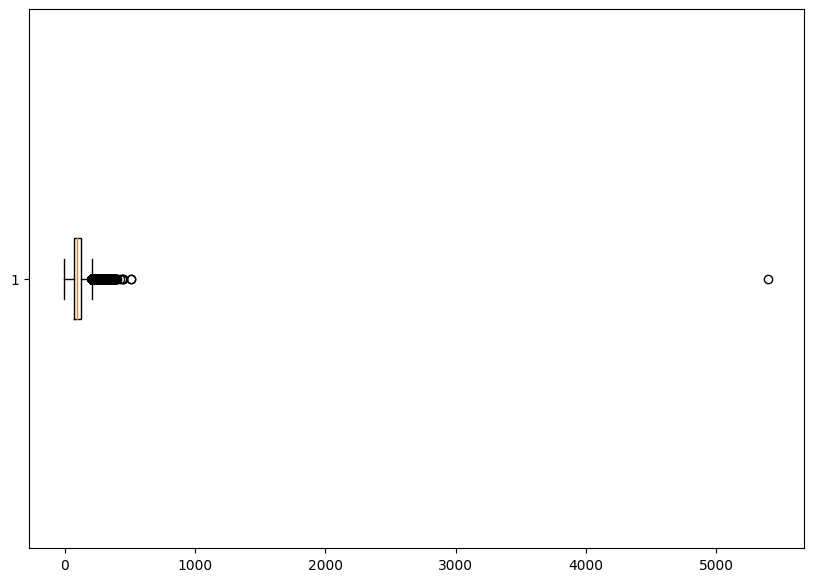

In [ ]:
fig = plt.figure(figsize = (10,7))
plt.boxplot(df['ADR'], vert = False)
plt.show()

In [ ]:
price_thres_max = df['ADR'].quantile(0.9999)
price_thres_max

388.0

In [ ]:
n = df.shape[0]
df = df[df['ADR'] <= price_thres_max*(1+0.5)] # 0.5 se conoce como delta (tolerancias)
print('Dropping high prices', n-df.shape[0])

Dropping high prices 1


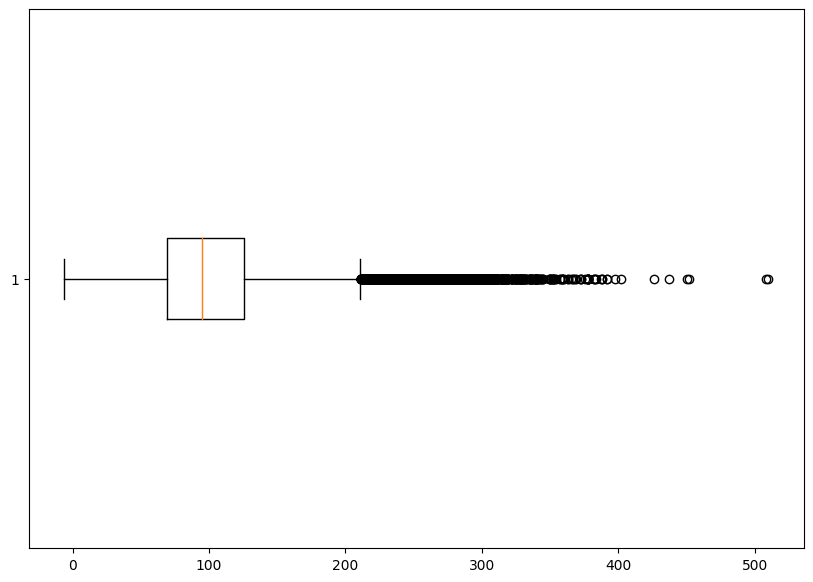

In [ ]:
fig = plt.figure(figsize = (10,7))
plt.boxplot(df['ADR'], vert = False)
plt.show()

## Registros con varias columnas nulas

Generar un nuevo dataframe (df_wout_null) en el que descarten registros con varias columnas nulas (más de 4). Por lo que hemos visto sólo hay 2 columnas con muchos nulos.

In [ ]:
df['null_count'] = df.isnull().sum(axis='columns')
df

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,HotelId,null_count
0,False,342,2015,July,27,1,0,0,2,0.0,...,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,2
1,False,737,2015,July,27,1,0,0,2,0.0,...,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,2
2,False,7,2015,July,27,1,0,1,1,0.0,...,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,2
3,False,13,2015,July,27,1,0,1,1,0.0,...,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,1
4,False,14,2015,July,27,1,0,2,2,0.0,...,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,False,23,2017,August,35,30,2,5,2,0.0,...,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06,2,1
119386,False,102,2017,August,35,31,2,5,3,0.0,...,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07,2,1
119387,False,34,2017,August,35,31,2,5,2,0.0,...,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07,2,1
119388,False,109,2017,August,35,31,2,5,2,0.0,...,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07,2,1


In [ ]:
df[df['null_count'] >= 3]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,HotelId,null_count
30,False,118,2015,July,27,1,4,10,1,0.0,...,NaN,0,Transient,62.0,0,2,Check-Out,2015-07-15,1,3
7860,True,39,2016,August,36,30,0,5,2,0.0,...,NaN,0,Transient,159.0,0,5,Canceled,2016-07-22,1,3
13810,False,66,2015,September,39,26,4,6,2,0.0,...,NaN,0,Transient,115.0,1,2,Check-Out,2015-10-06,1,3
13811,True,71,2016,July,29,14,3,8,2,0.0,...,NaN,0,Transient,126.6,0,1,Canceled,2016-07-12,1,3
13830,False,6,2016,June,24,8,0,1,1,0.0,...,NaN,0,Transient,90.0,0,0,Check-Out,2016-06-09,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26473,False,19,2016,July,31,28,1,3,2,0.0,...,NaN,0,Transient,288.1,0,3,Check-Out,2016-08-01,1,3
28460,False,0,2016,October,41,3,1,0,2,0.0,...,NaN,0,Transient,87.0,1,0,Check-Out,2016-10-04,1,3
31594,False,31,2016,December,53,30,0,2,1,0.0,...,NaN,0,Transient-Party,222.5,0,1,Check-Out,2017-01-01,1,3
40600,True,2,2015,August,32,3,1,0,2,NaN,...,NaN,0,Transient-Party,12.0,0,1,Canceled,2015-08-01,2,3


In [ ]:
del df['null_count'] #Borramos null_count

In [ ]:
df.isnull().sum()

IsCanceled                          0
LeadTime                            0
ArrivalDateYear                     0
ArrivalDateMonth                    0
ArrivalDateWeekNumber               0
ArrivalDateDayOfMonth               0
StaysInWeekendNights                0
StaysInWeekNights                   0
Adults                              0
Children                            4
Babies                              0
Meal                                0
Country                           488
MarketSegment                       0
DistributionChannel                 0
IsRepeatedGuest                     0
PreviousCancellations               0
PreviousBookingsNotCanceled         0
ReservedRoomType                    0
AssignedRoomType                    0
BookingChanges                      0
DepositType                         0
Agent                           16340
Company                        112592
DaysInWaitingList                   0
CustomerType                        0
ADR         

### Estrategias para la Imputación de nulos

**Variables numéricas**
- Imputar valor constante
- Imputar media/mediana
- Imputar mediana en cada grupo
- Utilizar una regresión lineal
- Modelo de KNN

**Variables categóricas**
- Generar nueva categoría
- Imputar la moda
- Inferir la categoría con un modelo

Tan sólo tenemos nulos en variables categóricas muy cardinales. Ninguna de las estrategias de nulos sería viable.

# **EDA**

## Analisis Univariante

### Variables numéricas

La mejor manera para visualizar la distribución es con una histograma + density plot.


In [ ]:
# Visualizar distribucion de todas las variables numéricas
df_num = df.select_dtypes(include=['int64','float64'])
list(df_num.columns)

['LeadTime',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests']

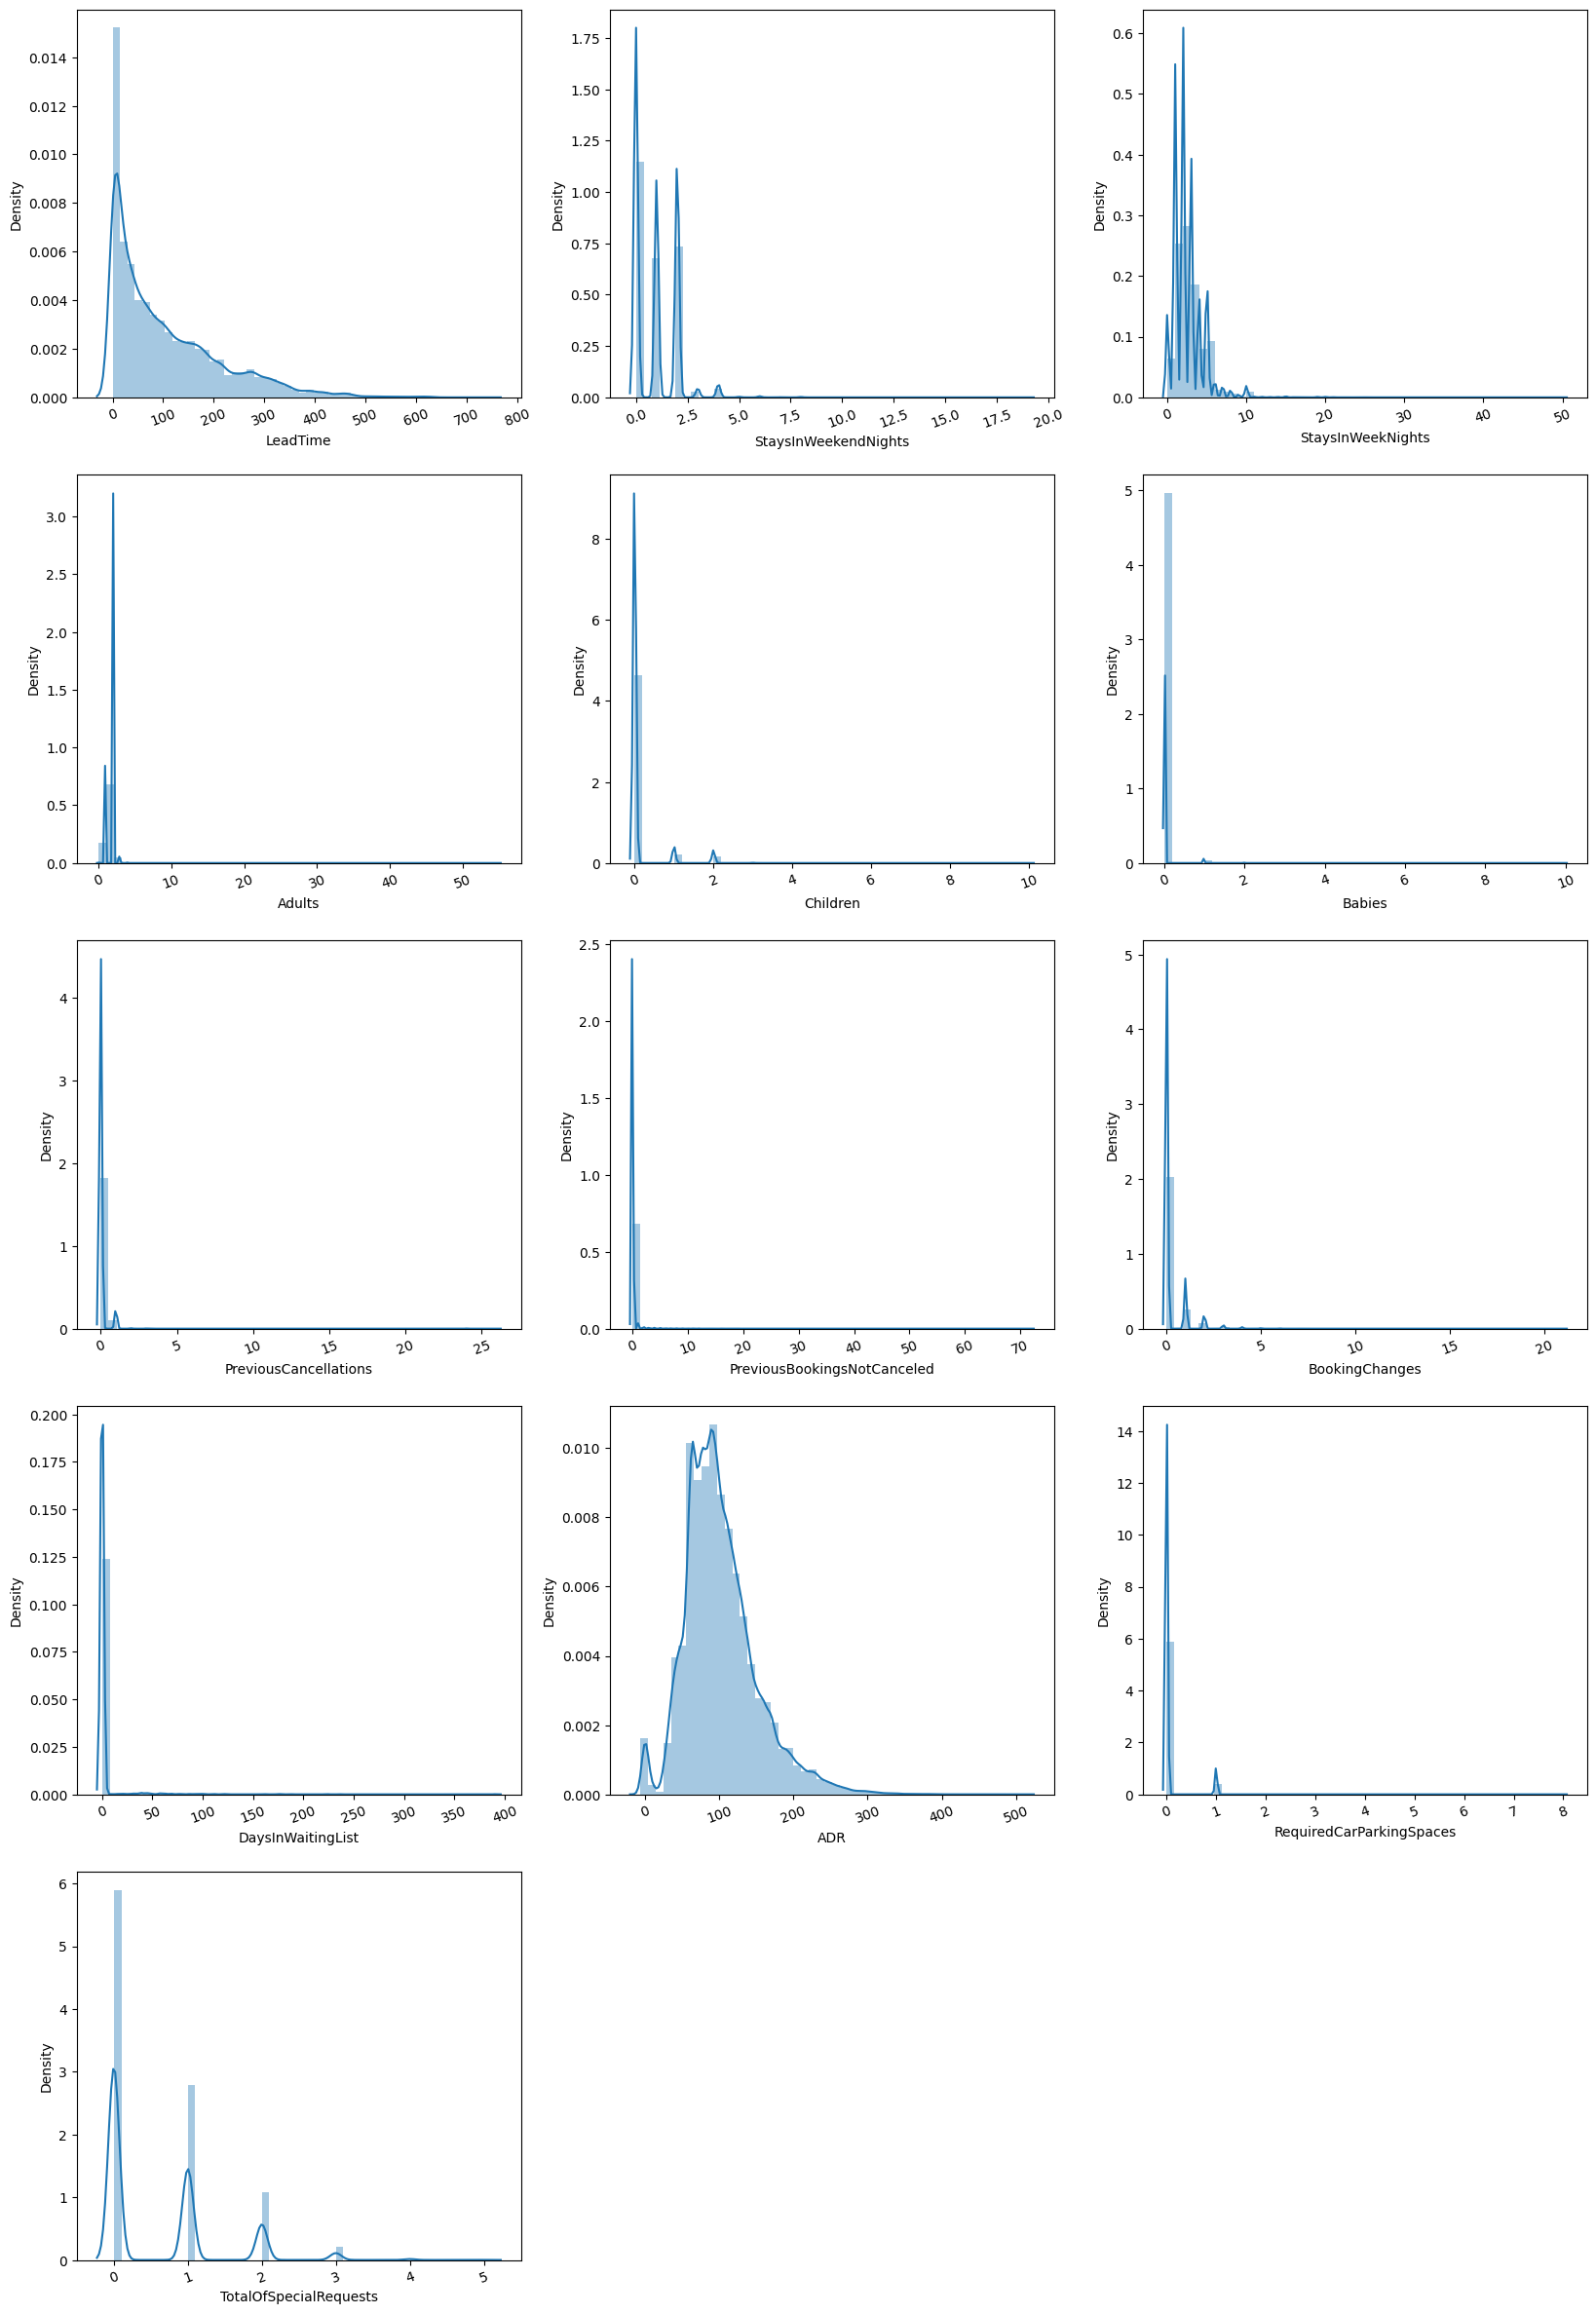

In [ ]:
plt.figure(figsize=(20, 30))
features = df_num.columns[0:]
for i in enumerate(features):
    ax = plt.subplot(5, 3, i[0]+1)
    sns.distplot(df_num[i[1]])
    plt.xticks(rotation=20)

Vemos que tenemos muchas distribución infladas en el 0. Este tipo de distribuciones no son ideales para modelos geométricos ni como variable objetivo.

Algunas transformaciones:
- Logaritmo (cuidado con 0 y valores negativos)
- Raíz cuadrada (cuidado con valores negativos)

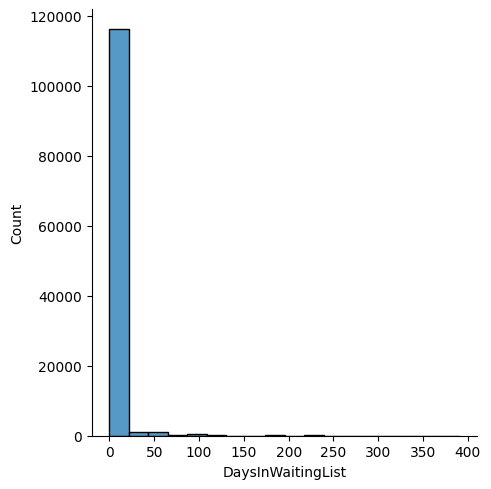

In [ ]:
var = 'DaysInWaitingList'

sns.displot(df[var])
plt.show()

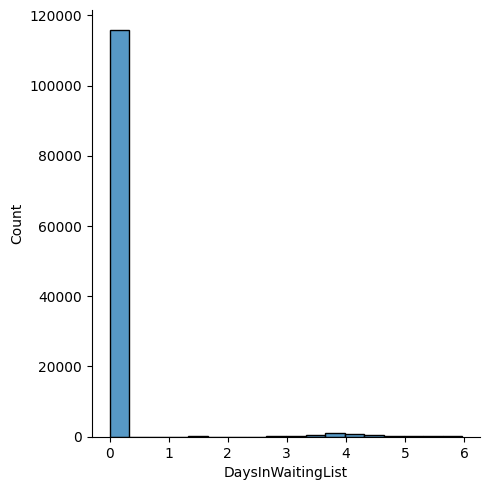

In [ ]:
sns.displot(np.log(df[var]+1)) #Sigue estando inflada a 0
plt.show()

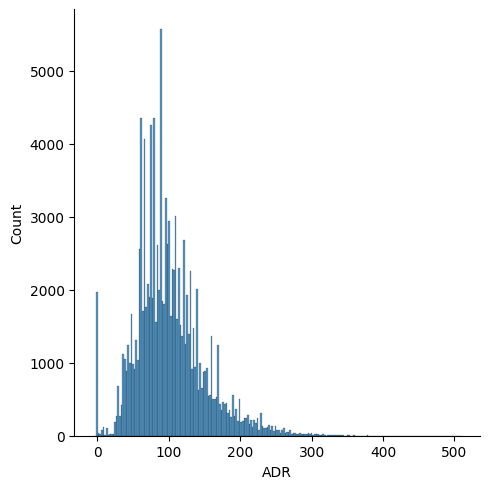

In [ ]:
var1 = 'ADR'

sns.displot(df[var1])
plt.show()

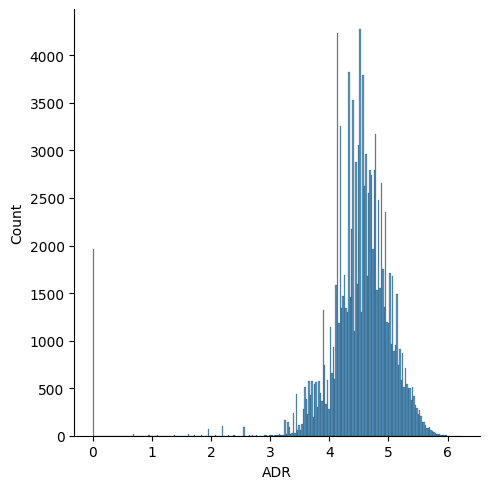

In [ ]:
sns.displot(np.log(df[var1]+1)) #No es que mejore mucho pero es común aplicar logaritmos
plt.show()

### Variables categóricas

La mejor manera es con un gráfico de barras.

In [ ]:
# Visualizar distribucion de todas las variables categóricas
df_cat = df.select_dtypes(exclude=['number'])
list(df_cat.columns)

['IsCanceled',
 'ArrivalDateYear',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'IsRepeatedGuest',
 'ReservedRoomType',
 'AssignedRoomType',
 'DepositType',
 'Agent',
 'Company',
 'CustomerType',
 'ReservationStatus',
 'ReservationStatusDate',
 'HotelId']

Cuidado hay variables con muchos valores únicos! Representarlas en una gráfica puede ser un desastre.

In [ ]:
cats_per_col = df_cat.nunique().to_frame() #Cuenta los distintos elementos en un eje especificado, no toma en cuenta los Null
cats_per_col

,0
IsCanceled,2
ArrivalDateYear,3
ArrivalDateMonth,12
ArrivalDateWeekNumber,53
ArrivalDateDayOfMonth,31
Meal,5
Country,177
MarketSegment,8
DistributionChannel,5
IsRepeatedGuest,2


In [ ]:
cats_per_col = cats_per_col[cats_per_col[0] <= 31]
cats_per_col

,0
IsCanceled,2
ArrivalDateYear,3
ArrivalDateMonth,12
ArrivalDateDayOfMonth,31
Meal,5
MarketSegment,8
DistributionChannel,5
IsRepeatedGuest,2
ReservedRoomType,10
AssignedRoomType,12


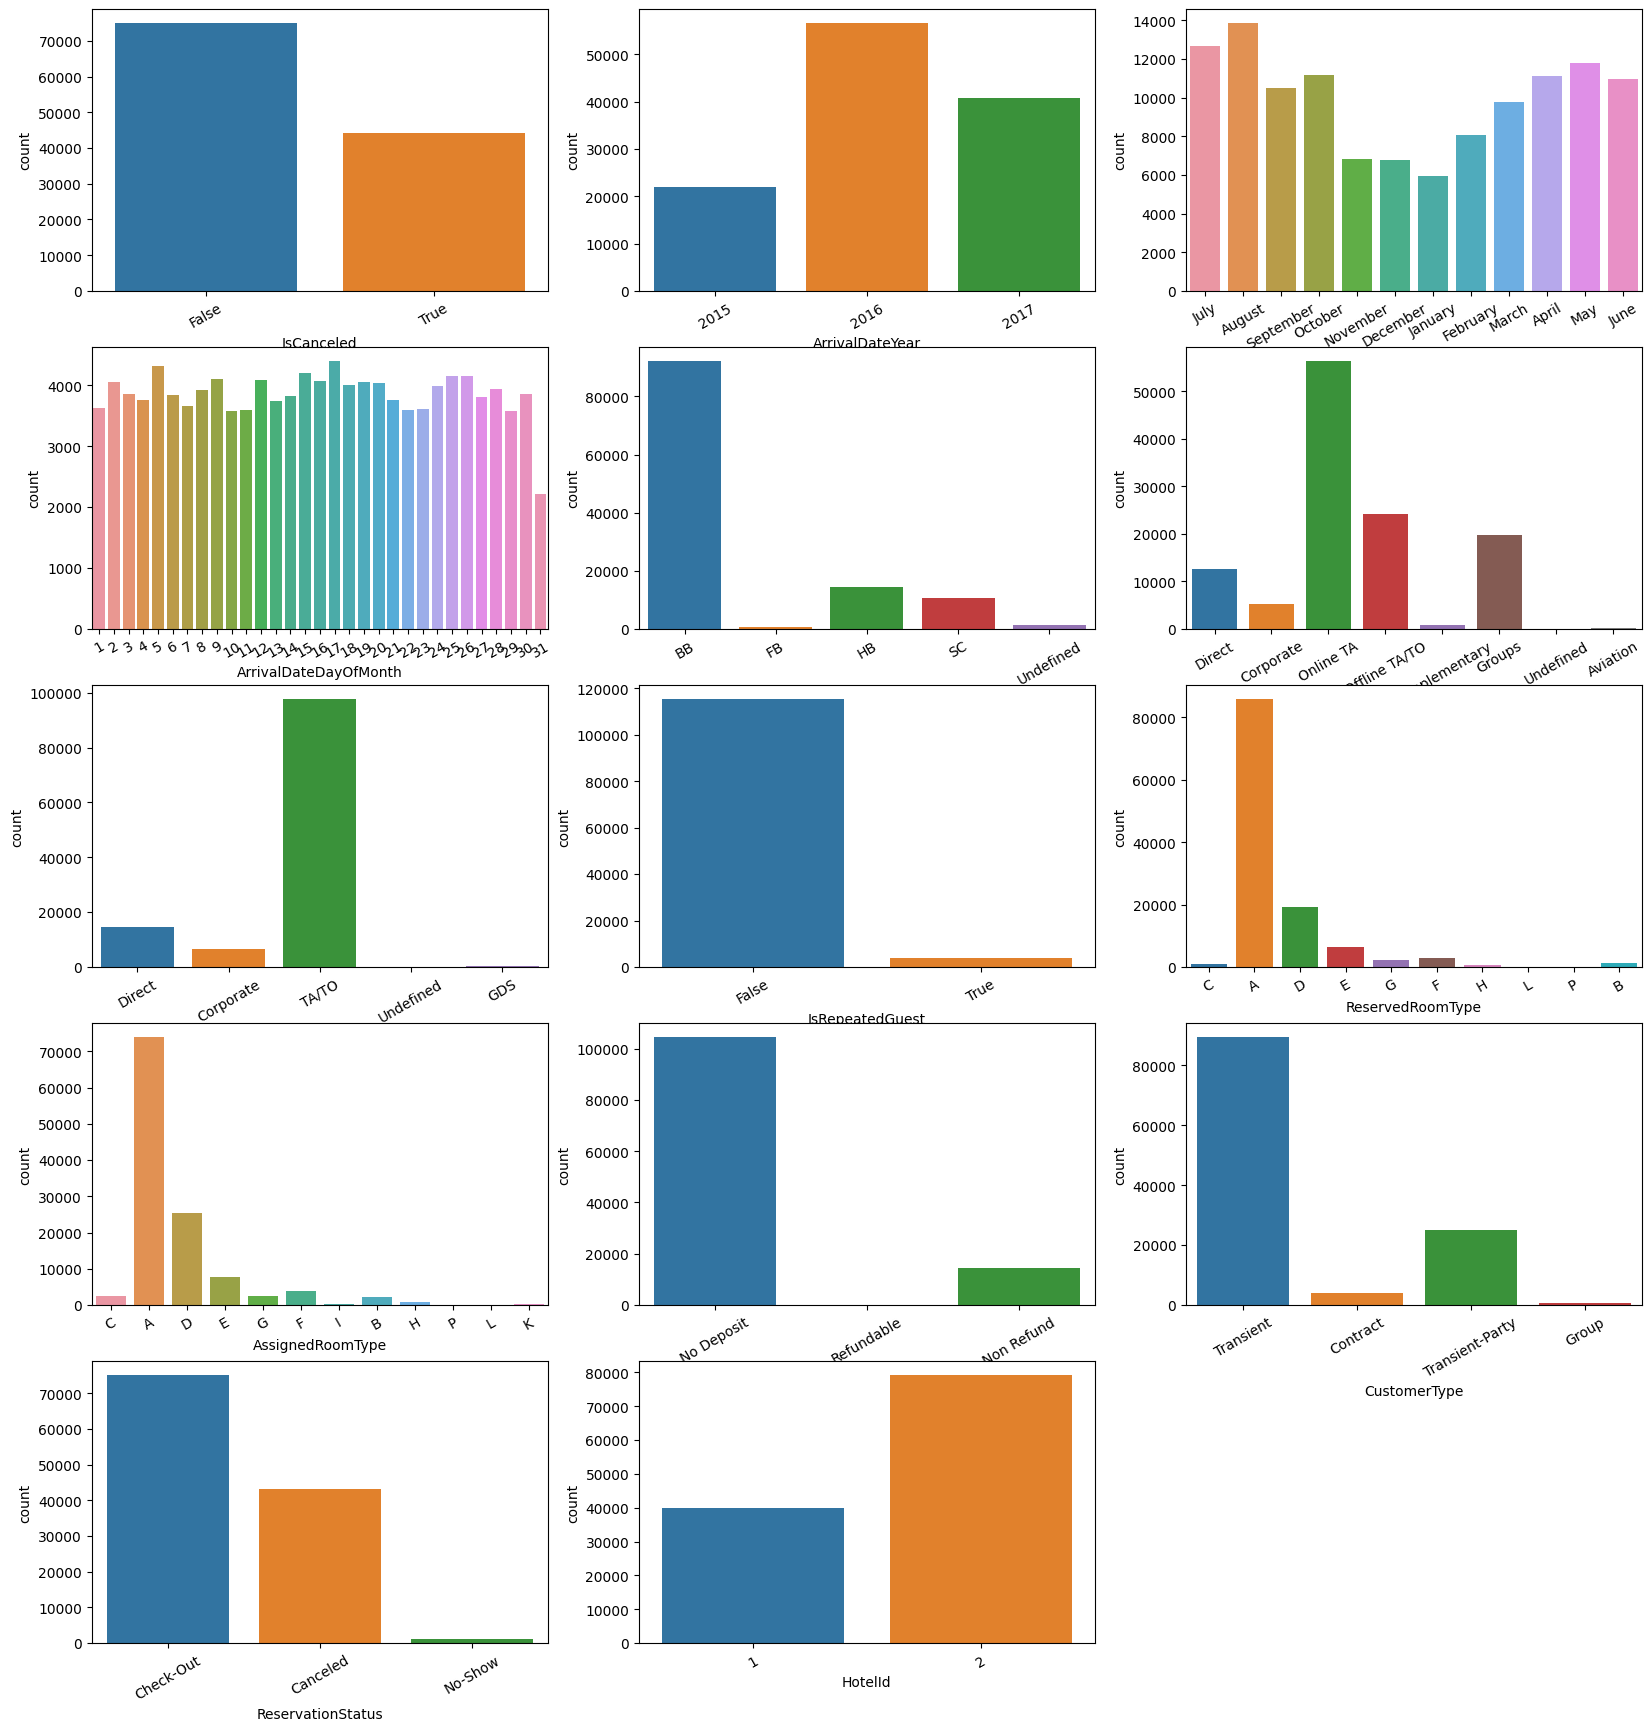

In [ ]:
plt.figure(figsize=(20, 30))
features = cats_per_col.index

for i in enumerate(features):
    ax = plt.subplot(7, 3, i[0]+1)
    sns.countplot(df_cat, x=i[1])
    plt.xticks(rotation=30)
plt.show()

In [ ]:
df[TARGET].value_counts(normalize=True) # 37% de las reservas se han cancelado

False    0.629589
True     0.370411
Name: IsCanceled, dtype: float64

## Análisis Multivariante

Cómo se relaciona cada una de las variables con el target y cómo se relacionan entre ellas.

### Variables numéricas

Dado que nuestro target es una variable categórica (Clasificación) la mejor manera de observar patrones es un violin plot, boxplot, boxenplot... pero también se puede utilizar scatterplots.

Antes de todo observemos correlaciones entre variables numéricas.

In [ ]:
#Correlation matrix
corr = df.corr()
corr

,IsCanceled,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
IsCanceled,1.000000,0.293133,-0.001781,0.024773,0.060015,0.005051,-0.032490,-0.084792,0.110135,-0.057357,-0.144396,0.054188,0.048708,-0.195496,-0.234652
LeadTime,0.293133,1.000000,0.085667,0.165796,0.119520,-0.037623,-0.020915,-0.124411,0.086041,-0.073549,0.000155,0.170084,-0.065603,-0.116452,-0.095716
StaysInWeekendNights,-0.001781,0.085667,1.000000,0.498966,0.091873,0.045791,0.018482,-0.087241,-0.012775,-0.042716,0.063291,-0.054152,0.052639,-0.018556,0.072666
StaysInWeekNights,0.024773,0.165796,0.498966,1.000000,0.092977,0.044201,0.020190,-0.097246,-0.013993,-0.048743,0.096218,-0.002021,0.069190,-0.024861,0.068187
Adults,0.060015,0.119520,0.091873,0.092977,1.000000,0.030447,0.018146,-0.146426,-0.006738,-0.107983,-0.051676,-0.008283,0.241824,0.014785,0.122885
Children,0.005051,-0.037623,0.045791,0.044201,0.030447,1.000000,0.024029,-0.032860,-0.024730,-0.021073,0.048952,-0.033273,0.341168,0.056252,0.081743
Babies,-0.032490,-0.020915,0.018482,0.020190,0.018146,0.024029,1.000000,-0.008943,-0.007501,-0.006551,0.083441,-0.010621,0.030705,0.037383,0.097889
IsRepeatedGuest,-0.084792,-0.124411,-0.087241,-0.097246,-0.146426,-0.032860,-0.008943,1.000000,0.082293,0.418056,0.012094,-0.022235,-0.140792,0.077089,0.013049
PreviousCancellations,0.110135,0.086041,-0.012775,-0.013993,-0.006738,-0.024730,-0.007501,0.082293,1.000000,0.152728,-0.026992,0.005929,-0.068798,-0.018492,-0.048385
PreviousBookingsNotCanceled,-0.057357,-0.073549,-0.042716,-0.048743,-0.107983,-0.021073,-0.006551,0.418056,0.152728,1.000000,0.011609,-0.009397,-0.075629,0.047653,0.037823


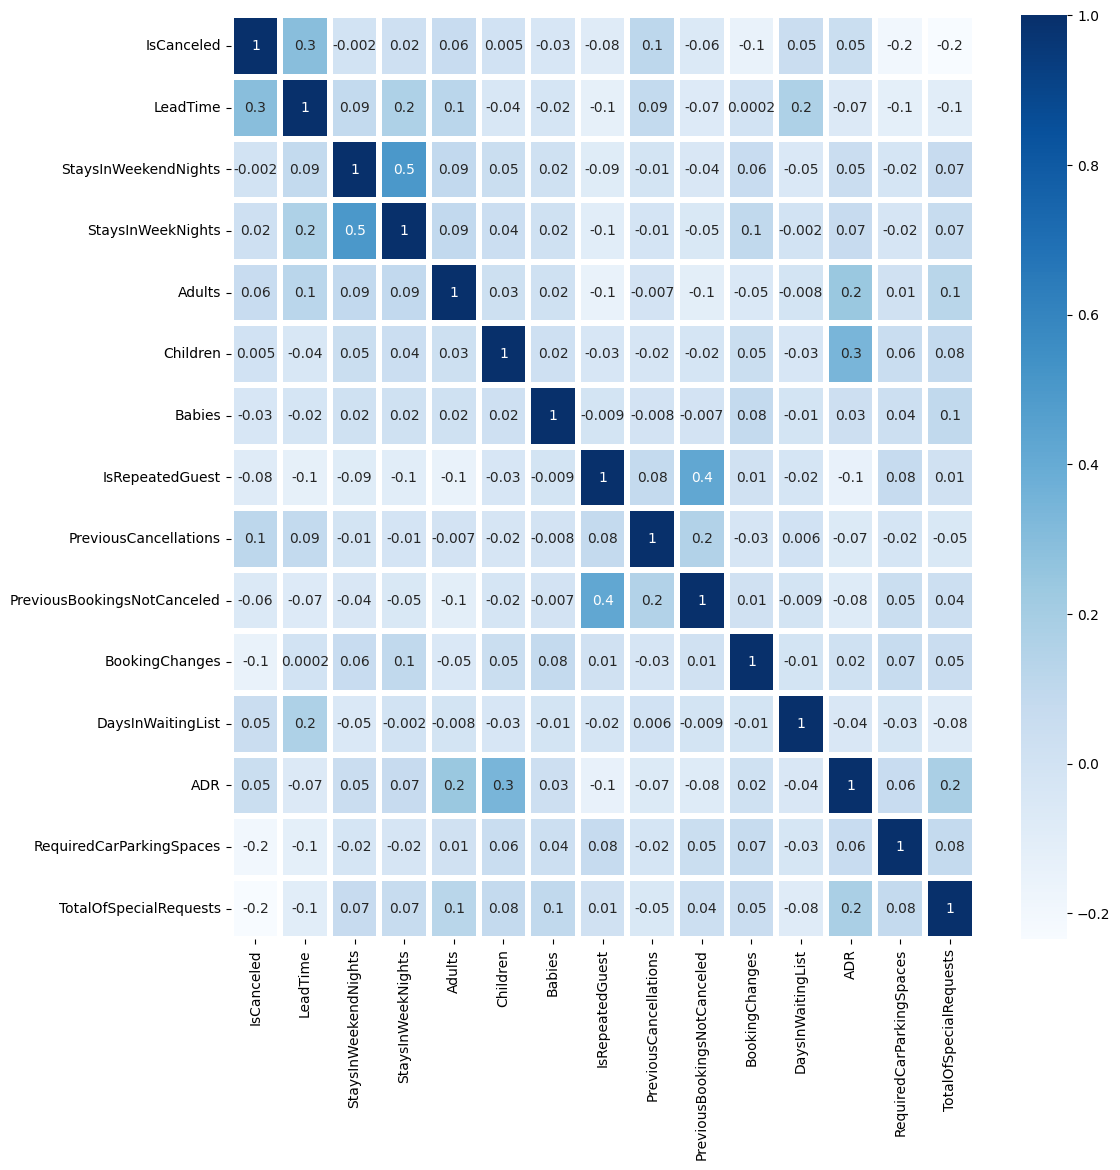

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.heatmap(df.corr(),cmap='Blues', annot=True, linewidths = 3, fmt = ".1g", annot_kws={"size":10})
plt.show()

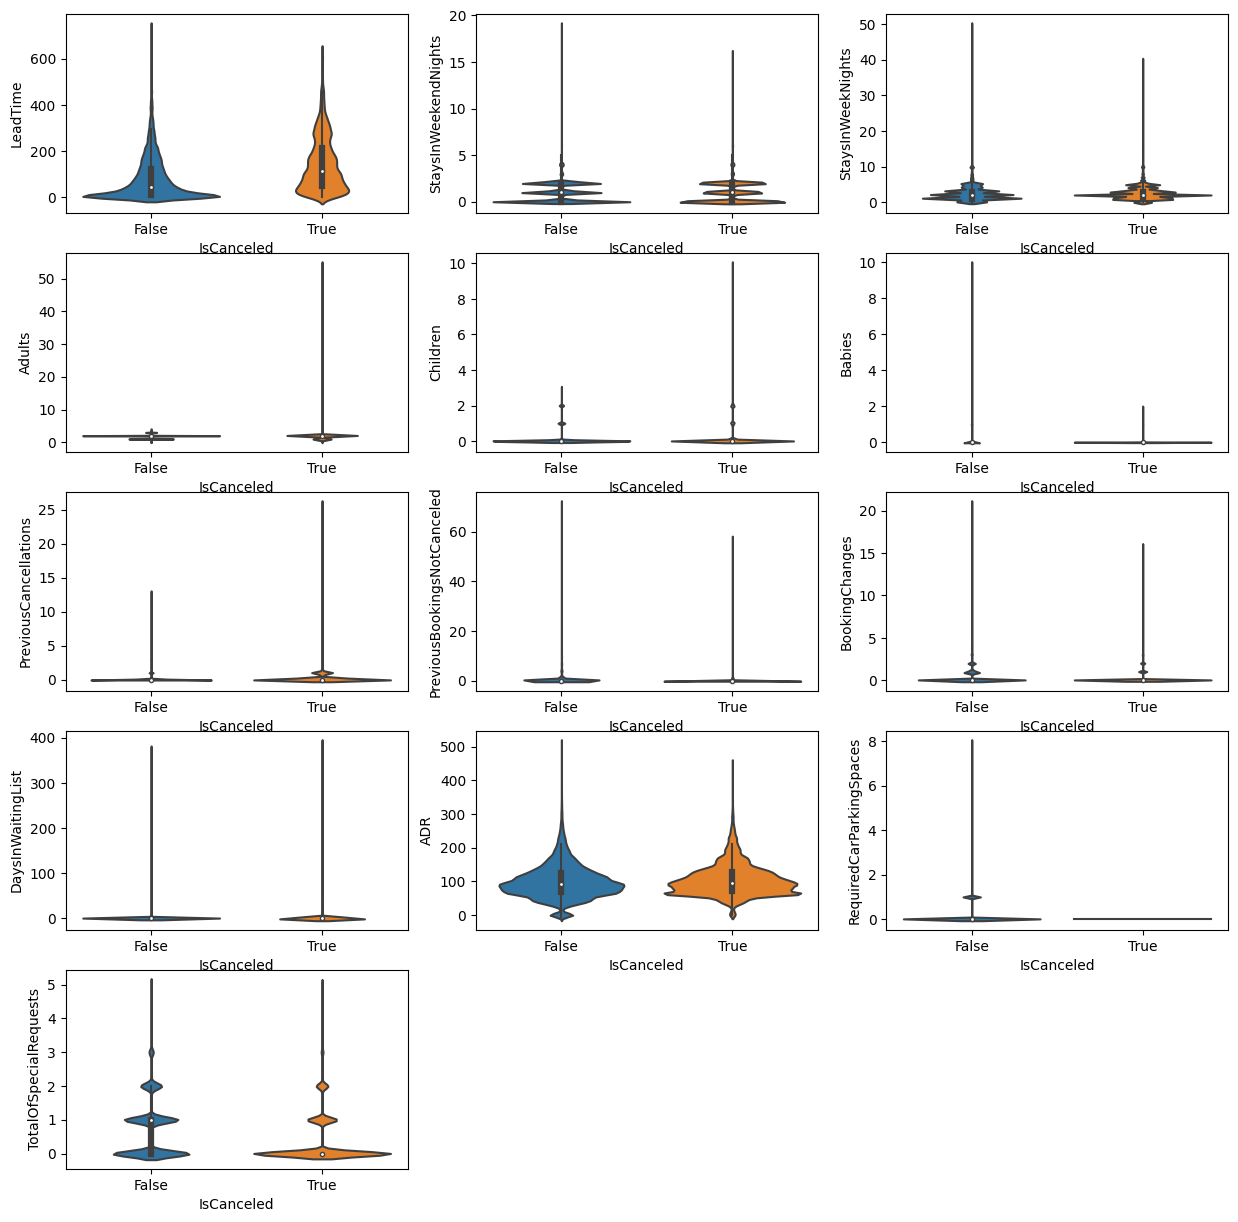

In [ ]:
plt.figure(figsize=(15, 15))
features = list(df_num.columns)

for i in enumerate(features):
    ax = plt.subplot(5, 3, i[0]+1)
    sns.violinplot(df, y=i[1], x=TARGET)

In [ ]:
# El precio parece no influir en las cancelaciones

Combinemos 3 variables (LeadTime - Antelación de las reservas, ADR - Precio medio de la reserva por noche y el Target).

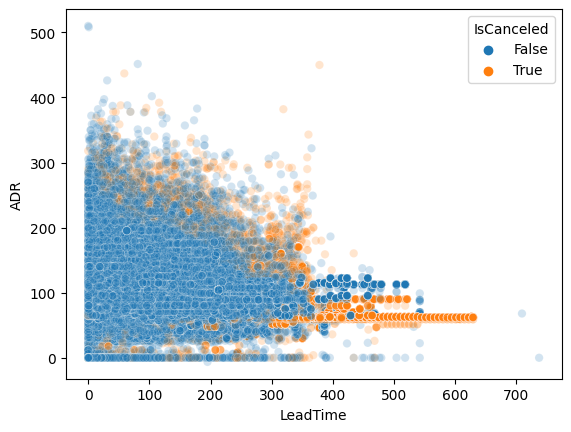

In [ ]:
sns.scatterplot(x='LeadTime', y='ADR', hue='IsCanceled', data=df, alpha=0.2)
plt.show()

Se cancelan las reservas que sean hechas con más días de antelación

¿Qué mes la gente viaja y se gasta más? Distinguir por hotel.

In [ ]:
def plot_cat_num_values(dataframe, column, target_column):

    plt.figure(figsize=(12,8))
    ax1 = plt.subplot(2,1,1)

    ## Graficamos el conteo de cada uno de los valores
    ax1 = sns.countplot(
        data = dataframe, x=column
    )

    ax2 = plt.subplot(2,1,2, sharex=ax1)

    ## Graficamos la distribución del target
    ax2 = sns.boxenplot(
        data = dataframe,
        x = column,
        y = target_column
    )

    plt.show()

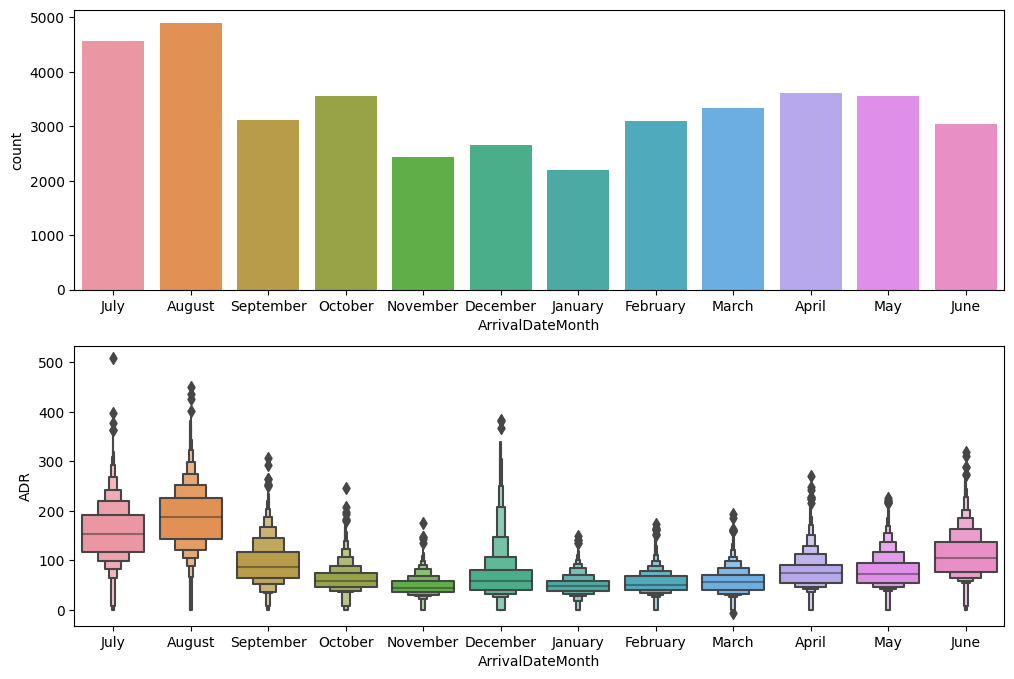

In [ ]:
plot_cat_num_values(df[df['HotelId'] == 1], 'ArrivalDateMonth', 'ADR')

Agosto la gente viaja mucho más, y gasta de precio medio mucho más

### Variables categóricas

Visualizar este tipo de variables es más complicado.

In [ ]:
features = cats_per_col.index
features

Index(['IsCanceled', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateDayOfMonth', 'Meal', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'ReservedRoomType', 'AssignedRoomType',
       'DepositType', 'CustomerType', 'ReservationStatus', 'HotelId'],
      dtype='object')

In [ ]:
df.groupby(['ArrivalDateYear','IsCanceled'])['LeadTime'].count().to_frame()

LeadTime
ArrivalDateYear IsCanceled          
2015            False          13854
                True            8142
2016            False          36370
                True           20336
2017            False          24942
                True           15745

In [ ]:
def plot_cat_cat_values(dataframe, column, target_column):

    plt.figure(figsize=(12,8))
    ax1 = plt.subplot(2,1,1)

    ## Graficamos el conteo de cada uno de los valores
    ax1 = sns.countplot(
        data = dataframe, x=column
    )

    ax2 = plt.subplot(2,1,2, sharex=ax1)

    ## Graficamos la distribución del target
    ax2 = sns.countplot(
        data = dataframe,
        x = column,
        hue = target_column
    )

    plt.show()

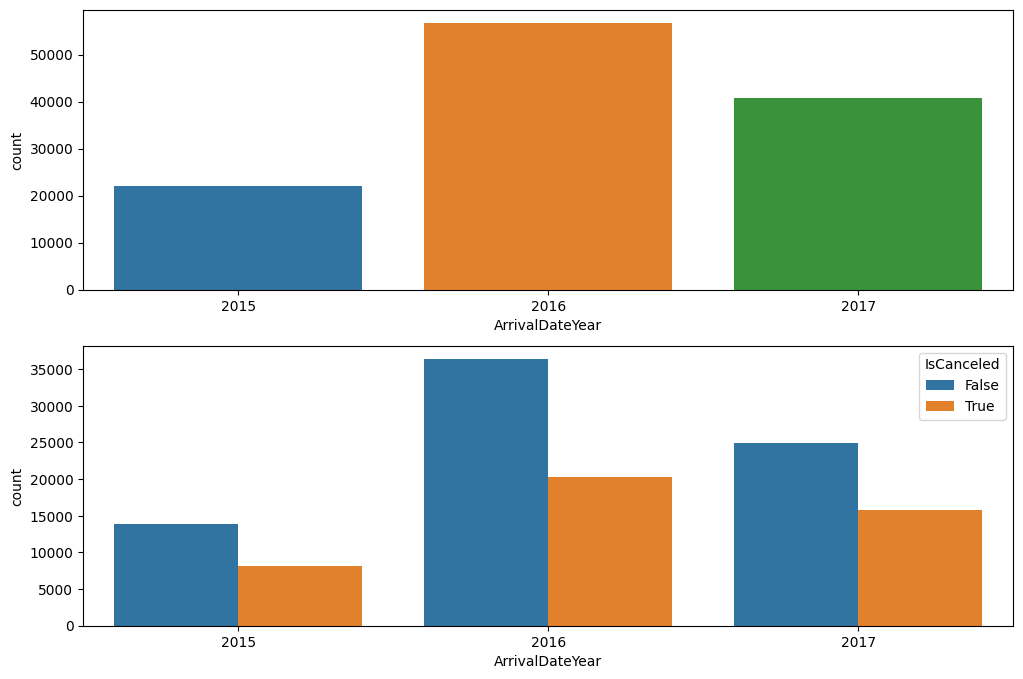

In [ ]:
plot_cat_cat_values(df,'ArrivalDateYear', 'IsCanceled')

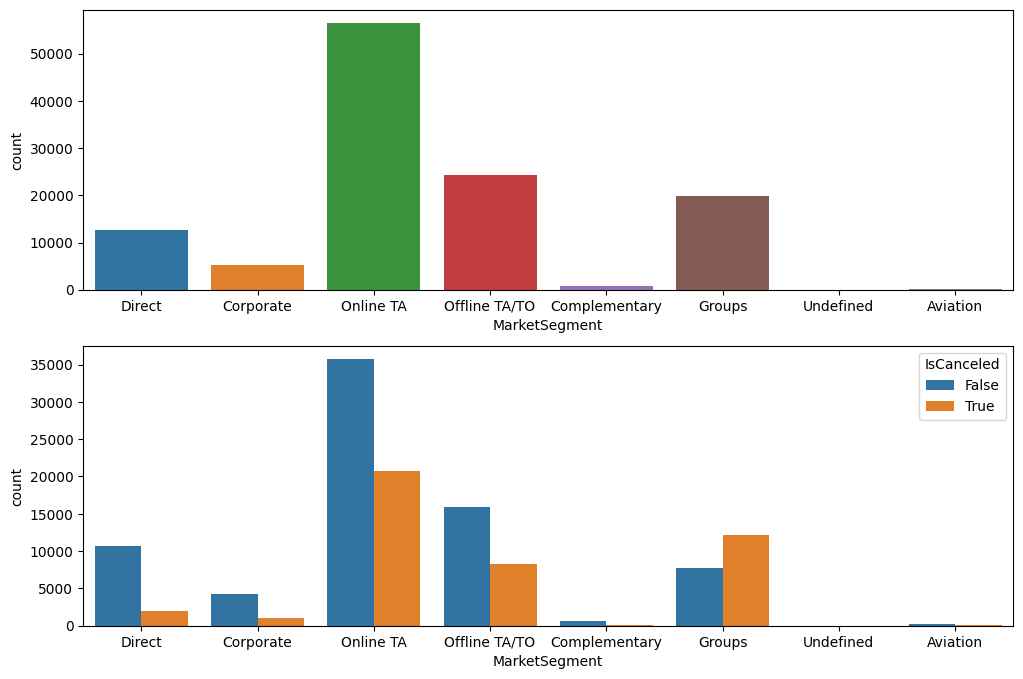

In [ ]:
plot_cat_cat_values(df,'MarketSegment', 'IsCanceled')

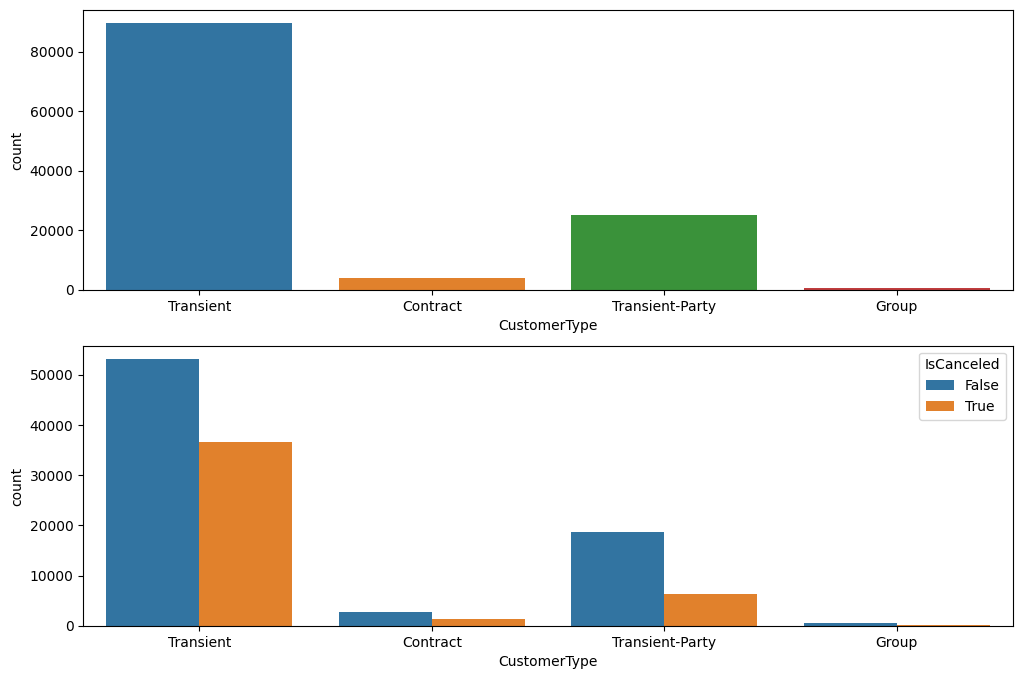

In [ ]:
plot_cat_cat_values(df,'CustomerType', 'IsCanceled')

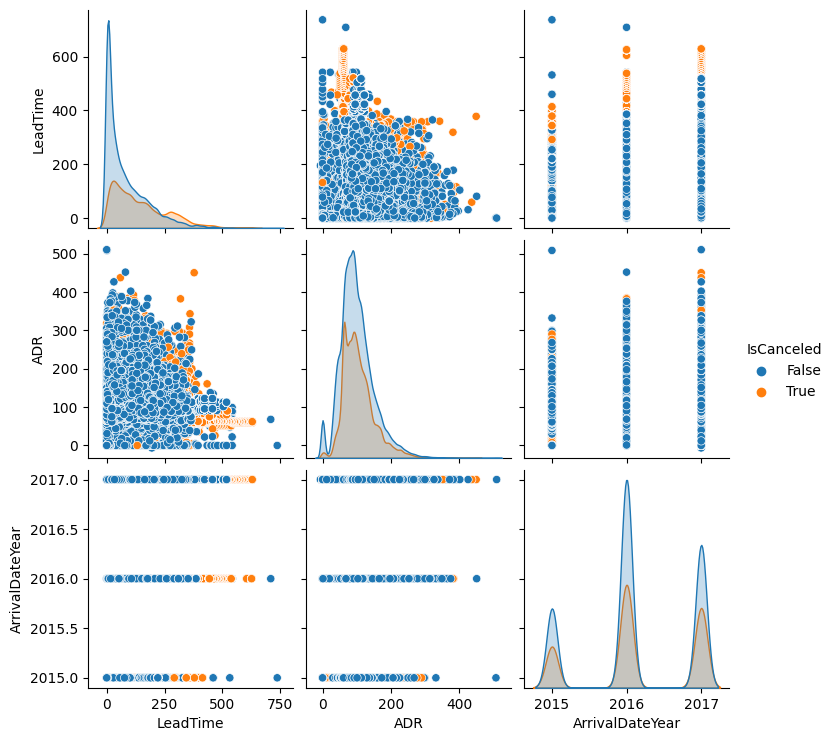

In [ ]:
cols = ['LeadTime', 'ADR', 'ArrivalDateMonth', 'ArrivalDateYear', 'IsCanceled']
sns.pairplot(df[cols], hue='IsCanceled')
plt.show()

## Series Temporales

Las columnas corresponden a una fecha: 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateDayOfMonth'.

In [ ]:
df['ArrivalDate_str'] =  df['ArrivalDateMonth'].astype(str) + ' ' + \
    df['ArrivalDateDayOfMonth'].astype(str) + ', '+ df['ArrivalDateYear'].astype(str)
df['ArrivalDate_str']

0            July 1, 2015
1            July 1, 2015
2            July 1, 2015
3            July 1, 2015
4            July 1, 2015
               ...       
119385    August 30, 2017
119386    August 31, 2017
119387    August 31, 2017
119388    August 31, 2017
119389    August 29, 2017
Name: ArrivalDate_str, Length: 119389, dtype: object

In [ ]:
df['ArrivalDate'] = pd.to_datetime(df['ArrivalDate_str'], infer_datetime_format=True)
df['ArrivalDate']

0        2015-07-01
1        2015-07-01
2        2015-07-01
3        2015-07-01
4        2015-07-01
            ...    
119385   2017-08-30
119386   2017-08-31
119387   2017-08-31
119388   2017-08-31
119389   2017-08-29
Name: ArrivalDate, Length: 119389, dtype: datetime64[ns]

In [ ]:
df['LengthOfStay'] = df['StaysInWeekendNights'] + df['StaysInWeekNights']
df['Revenue'] = df['ADR']*df['LengthOfStay']

In [ ]:
revenue_hotel_dates = df[df[TARGET]==False].groupby(['HotelId','ArrivalDate'])['Revenue'].sum().to_frame()
revenue_hotel_dates.reset_index(inplace=True)
revenue_hotel_dates

,HotelId,ArrivalDate,Revenue
0,1,2015-07-01,15480.76
1,1,2015-07-02,19438.44
2,1,2015-07-03,13965.09
3,1,2015-07-04,19287.04
4,1,2015-07-05,23756.85
...,...,...,...
1576,2,2017-08-27,25886.94
1577,2,2017-08-28,46679.82
1578,2,2017-08-29,25453.91
1579,2,2017-08-30,14605.37


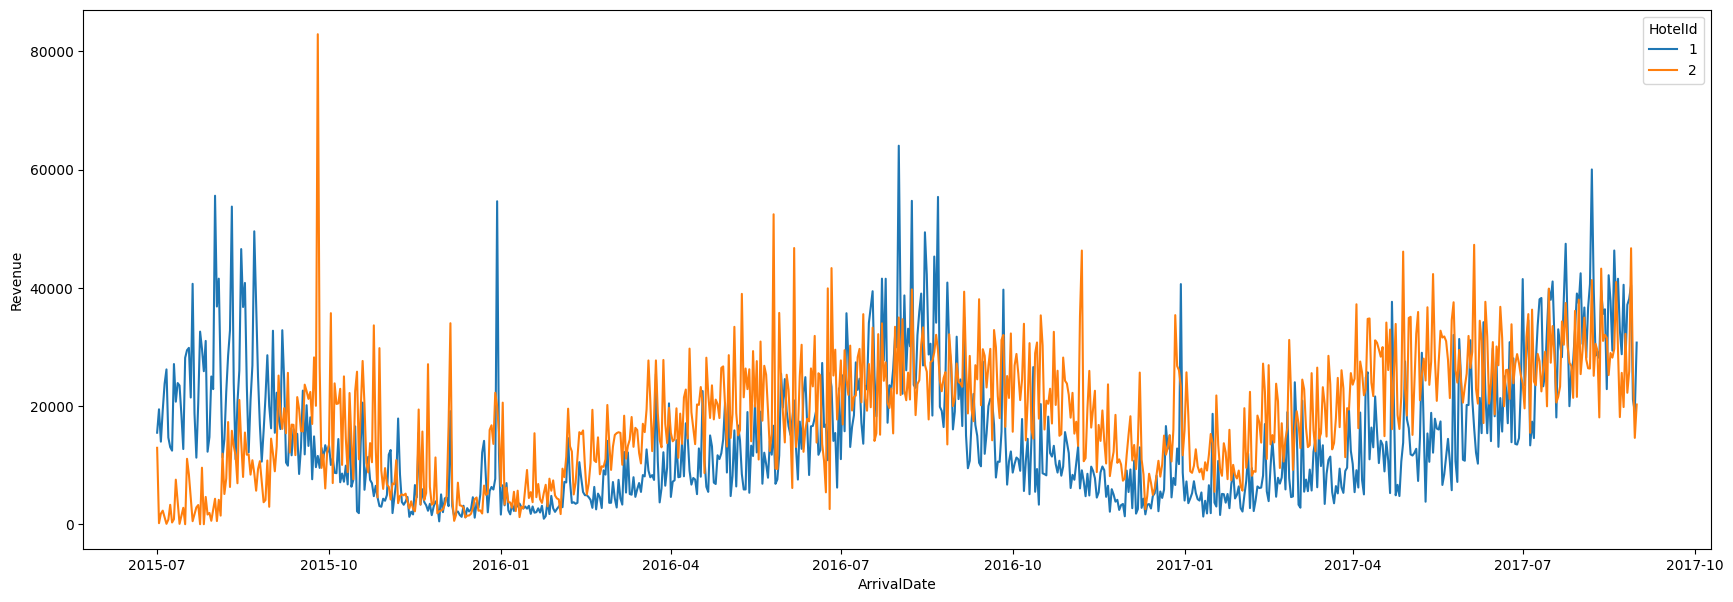

In [ ]:
# figure size in inches
rcParams['figure.figsize'] = 21, 7

sns.lineplot(x='ArrivalDate', y="Revenue", hue="HotelId", data=revenue_hotel_dates, palette="tab10")
plt.show()

In [ ]:
del df['ArrivalDate'], df['ArrivalDate_str']

# Data Transformation para ML

Objetivo: Preparar el dataset para entrenamiento de un modelo predictivo.

In [ ]:
df.isnull().sum()

IsCanceled                          0
LeadTime                            0
ArrivalDateYear                     0
ArrivalDateMonth                    0
ArrivalDateWeekNumber               0
ArrivalDateDayOfMonth               0
StaysInWeekendNights                0
StaysInWeekNights                   0
Adults                              0
Children                            4
Babies                              0
Meal                                0
Country                           488
MarketSegment                       0
DistributionChannel                 0
IsRepeatedGuest                     0
PreviousCancellations               0
PreviousBookingsNotCanceled         0
ReservedRoomType                    0
AssignedRoomType                    0
BookingChanges                      0
DepositType                         0
Agent                           16340
Company                        112592
DaysInWaitingList                   0
CustomerType                        0
ADR         

In [ ]:
num_report, cat_report = dist_report(df)
num_report

,dtype,nulls,%nulls,count,mean,std,min,25%,50%,75%,max
LeadTime,int64,0,0.0,119389.0,104.011994,106.863358,0.00,18.00,69.00,160.00,737.0
StaysInWeekendNights,int64,0,0.0,119389.0,0.927606,0.998614,0.00,0.00,1.00,2.00,19.0
StaysInWeekNights,int64,0,0.0,119389.0,2.500314,1.908289,0.00,1.00,2.00,3.00,50.0
Adults,int64,0,0.0,119389.0,1.856402,0.579263,0.00,2.00,2.00,2.00,55.0
Babies,int64,0,0.0,119389.0,0.007949,0.097437,0.00,0.00,0.00,0.00,10.0
PreviousCancellations,int64,0,0.0,119389.0,0.087119,0.844340,0.00,0.00,0.00,0.00,26.0
PreviousBookingsNotCanceled,int64,0,0.0,119389.0,0.137098,1.497443,0.00,0.00,0.00,0.00,72.0
BookingChanges,int64,0,0.0,119389.0,0.221118,0.652304,0.00,0.00,0.00,0.00,21.0
DaysInWaitingList,int64,0,0.0,119389.0,2.321169,17.594793,0.00,0.00,0.00,0.00,391.0
RequiredCarParkingSpaces,int64,0,0.0,119389.0,0.062518,0.245292,0.00,0.00,0.00,0.00,8.0


In [ ]:
cat_report

,dtype,nulls,%nulls,count,unique,top,freq
IsCanceled,bool,0,0.00,119389,2,False,75166
IsRepeatedGuest,bool,0,0.00,119389,2,False,115579
ArrivalDateMonth,object,0,0.00,119389,12,August,13877
ReservationStatus,object,0,0.00,119389,3,Check-Out,75166
CustomerType,object,0,0.00,119389,4,Transient,89612
Company,object,112592,94.31,6797,352,40,927
Agent,object,16340,13.69,103049,333,9,31961
DepositType,object,0,0.00,119389,3,No Deposit,104641
AssignedRoomType,object,0,0.00,119389,12,A,74052
ArrivalDateYear,object,0,0.00,119389,3,2016,56706


# Estrategias para preparación de los datos

## **Variables numéricas**
### Modelos geométricos
- Conversión de magnitud (aplicar logaritmo o reducciones de magnitud)
- Estandarización
- Normalización
- Tratamiento de outliers (clipping)

### Modelos lógicos
- Discretización de variables continuas (interesante para el tratamiento de nulos)
- Redondeo (o simplificación del tipo de variable. Feature importances incomprensibles)

## **Variables categóricas**
### Modelos geométricos
- Formato ordinal
- One Hot Encoding


### Modelos lógicos
- One Hot Encoding
- Formato ordinal
- Label Encoding
- Agrupamiento de categorías


In [ ]:
df_prep = df.copy(deep=True)

## Variables Numéricas
### Modelos geométricos
- Conversión de magnitud (aplicar logaritmo o reducciones de magnitud)

Expresar magnitudes en otra escala.
- aplicando logaritmos - cuidado con valores negativos.
- dividiendo entre 10, 100, 1.000, etc.
- raíz cuadrada

In [ ]:
rcParams['figure.figsize'] = 6, 3
var = 'ADR'

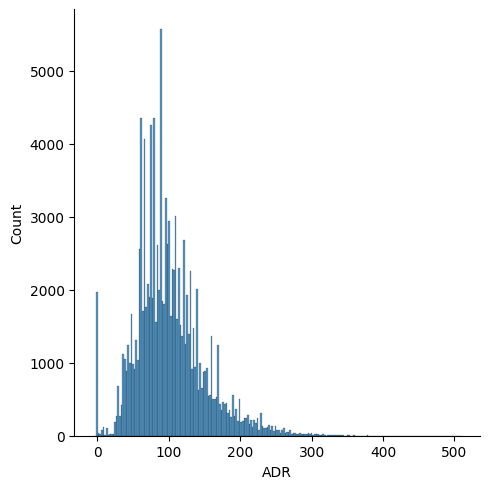

In [ ]:
sns.displot(df_num[var])

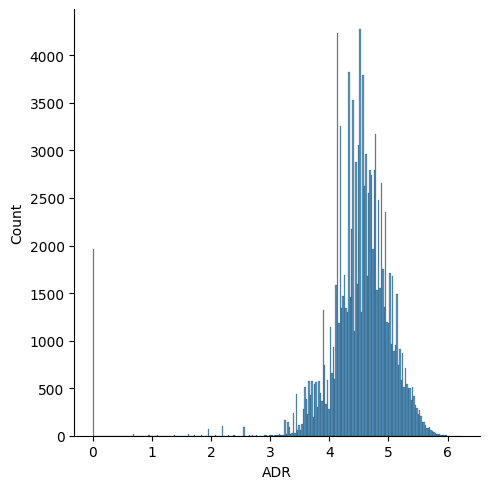

In [ ]:
sns.displot(np.log(df_num[var]+1))

- Estandarización

Expresar la columna en otra escala, de manera que la media quede en el 0 y las diferencias a la media queden expresadas en función de la desviación estándar.

$ Standard \ scaler = \frac{x - mean}{stddev}$

Tan sólo válido para variables numéricas!

In [ ]:
df_num = df_prep.select_dtypes(include=['int64','float64'])

In [ ]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df_num)

In [ ]:
np_scaled

array([[ 2.22704028, -0.92889767, -1.31024442, ..., -0.7206987 ,
        -1.34037757, -1.06619025],
       [ 5.92336483, -0.92889767, -1.31024442, ..., -0.7206987 ,
        -1.34037757, -1.06619025],
       [-0.90781726, -0.92889767, -0.78621249, ..., -0.7206987 ,
        -0.94935988, -0.84270525],
       ...,
       [-0.6551571 ,  1.07388643,  1.30991522, ...,  4.32473099,
         1.3967463 ,  2.22341958],
       [ 0.04667668,  1.07388643,  1.30991522, ..., -0.7206987 ,
         1.3967463 ,  1.11144761],
       [ 0.94502391,  1.07388643,  2.35797907, ...,  1.80201615,
         2.17878169,  2.98872162]])

In [ ]:
df_scaled = pd.DataFrame(np_scaled,columns = df_num.columns)
df_scaled

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,LengthOfStay,Revenue
0,2.227040,-0.928898,-1.310244,0.247898,-0.260664,-0.08158,-0.10318,-0.091555,4.260119,-0.131924,-2.113804,-0.254874,-0.720699,-1.340378,-1.066190
1,5.923365,-0.928898,-1.310244,0.247898,-0.260664,-0.08158,-0.10318,-0.091555,5.793152,-0.131924,-2.113804,-0.254874,-0.720699,-1.340378,-1.066190
2,-0.907817,-0.928898,-0.786212,-1.478440,-0.260664,-0.08158,-0.10318,-0.091555,-0.338980,-0.131924,-0.556280,-0.254874,-0.720699,-0.949360,-0.842705
3,-0.851671,-0.928898,-0.786212,-1.478440,-0.260664,-0.08158,-0.10318,-0.091555,-0.338980,-0.131924,-0.556280,-0.254874,-0.720699,-0.949360,-0.842705
4,-0.842313,-0.928898,-0.262181,0.247898,-0.260664,-0.08158,-0.10318,-0.091555,-0.338980,-0.131924,-0.078639,-0.254874,0.540659,-0.558342,-0.482149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119384,-0.758093,1.073886,1.309915,0.247898,-0.260664,-0.08158,-0.10318,-0.091555,-0.338980,-0.131924,-0.117266,-0.254874,-0.720699,1.396746,0.939156
119385,-0.018828,1.073886,1.309915,1.974236,-0.260664,-0.08158,-0.10318,-0.091555,-0.338980,-0.131924,2.567698,-0.254874,1.802016,1.396746,3.635964
119386,-0.655157,1.073886,1.309915,0.247898,-0.260664,-0.08158,-0.10318,-0.091555,-0.338980,-0.131924,1.161357,-0.254874,4.324731,1.396746,2.223420
119387,0.046677,1.073886,1.309915,0.247898,-0.260664,-0.08158,-0.10318,-0.091555,-0.338980,-0.131924,0.054269,-0.254874,-0.720699,1.396746,1.111448


- Normalización

Expresamos la variable entre 0 y 1. El mínimo será ahora 0 y el máximo 1.

$ Min-Max \ scaler = \frac{x - min}{max-min}$

In [ ]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit_transform(df_num)

array([[0.46404342, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00833573],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00833573],
       [0.00949796, 0.        , 0.02      , ..., 0.        , 0.01449275,
        0.01813478],
       ...,
       [0.04613297, 0.10526316, 0.1       , ..., 0.8       , 0.10144928,
        0.15257388],
       [0.14789688, 0.10526316, 0.1       , ..., 0.        , 0.10144928,
        0.10381771],
       [0.27815468, 0.10526316, 0.14      , ..., 0.4       , 0.13043478,
        0.18612977]])

In [ ]:
df_minmax = pd.DataFrame(minmax_scaler.fit_transform(df_num),columns = df_num.columns)
df_minmax

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,LengthOfStay,Revenue
0,0.464043,0.000000,0.00,0.036364,0.0,0.0,0.0,0.0,0.142857,0.0,0.012355,0.0,0.0,0.000000,0.008336
1,1.000000,0.000000,0.00,0.036364,0.0,0.0,0.0,0.0,0.190476,0.0,0.012355,0.0,0.0,0.000000,0.008336
2,0.009498,0.000000,0.02,0.018182,0.0,0.0,0.0,0.0,0.000000,0.0,0.157597,0.0,0.0,0.014493,0.018135
3,0.017639,0.000000,0.02,0.018182,0.0,0.0,0.0,0.0,0.000000,0.0,0.157597,0.0,0.0,0.014493,0.018135
4,0.018996,0.000000,0.04,0.036364,0.0,0.0,0.0,0.0,0.000000,0.0,0.202138,0.0,0.2,0.028986,0.033944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119384,0.031208,0.105263,0.10,0.036364,0.0,0.0,0.0,0.0,0.000000,0.0,0.198536,0.0,0.0,0.101449,0.096263
119385,0.138399,0.105263,0.10,0.054545,0.0,0.0,0.0,0.0,0.000000,0.0,0.448914,0.0,0.4,0.101449,0.214509
119386,0.046133,0.105263,0.10,0.036364,0.0,0.0,0.0,0.0,0.000000,0.0,0.317770,0.0,0.8,0.101449,0.152574
119387,0.147897,0.105263,0.10,0.036364,0.0,0.0,0.0,0.0,0.000000,0.0,0.214532,0.0,0.0,0.101449,0.103818


In [ ]:
df_minmax.describe()

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,LengthOfStay,Revenue
count,119389.000000,119389.000000,119389.000000,119389.000000,119385.000000,119389.000000,119389.000000,119389.000000,119389.000000,119389.000000,119389.000000,119389.000000,119389.000000,119389.000000,119389.000000
mean,0.141129,0.048821,0.050006,0.033753,0.010389,0.000795,0.003351,0.001904,0.010529,0.005936,0.209471,0.007815,0.114274,0.049680,0.055085
std,0.144998,0.052559,0.038166,0.010532,0.039856,0.009744,0.032475,0.020798,0.031062,0.044999,0.093252,0.030662,0.158560,0.037064,0.043847
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.024423,0.000000,0.020000,0.036364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.146539,0.000000,0.000000,0.028986,0.027411
50%,0.093623,0.052632,0.040000,0.036364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.195476,0.000000,0.000000,0.043478,0.043220
75%,0.217096,0.105263,0.060000,0.036364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256362,0.000000,0.200000,0.057971,0.066640
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Tratamiento de outliers (clipping)

Limitar valores muy extremos.

In [ ]:
num_var = 'Adults'

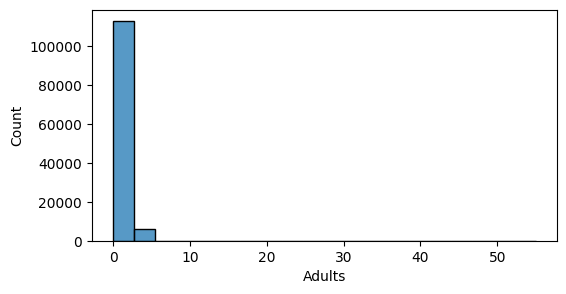

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df_prep[num_var], bins=20, ax=ax)
#sns.kdeplot(df_prep[num_var], ax=ax)
plt.show()

In [ ]:
df_prep[num_var].describe()

count    119389.000000
mean          1.856402
std           0.579263
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          55.000000
Name: Adults, dtype: float64

In [ ]:
df_prep[num_var+'_clip'] = df[num_var].clip(lower=0, upper=6)

In [ ]:
df_prep[num_var+'_clip'].describe()

count    119389.000000
mean          1.853881
std           0.490998
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           6.000000
Name: Adults_clip, dtype: float64

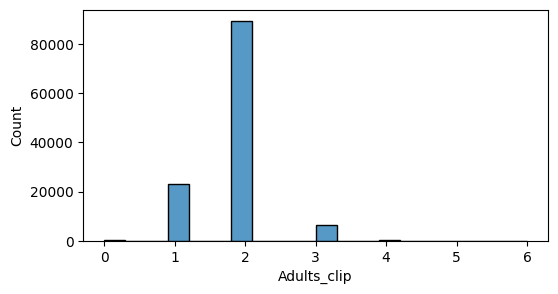

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df_prep[num_var+'_clip'], bins=20, ax=ax)
#sns.kdeplot(df_prep[num_var], ax=ax)
plt.show()


## Discretización de variables continuas

Convertir una variable numérica a categórica.

In [ ]:
num_var = 'Babies'

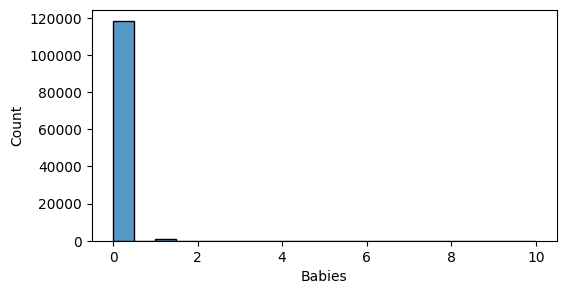

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df_prep[num_var], bins=20, ax=ax)
#sns.kdeplot(df_prep[num_var], ax=ax)
plt.show()

In [ ]:
# To bool
df_prep['Babies'] = df_prep['Babies'] > 0

In [ ]:
df_prep[num_var].value_counts()

False    118472
True        917
Name: Babies, dtype: int64

### cut (Esquidistante)

Extraemos el mínimo y el máximo de los datos de nuestra variables.
Y generamos un rango o delta:

$delta (\Delta) = \frac{max - min}{N}$

donde N (bins) es el número de tramos que queremos y delta el rango entre los tramos.

In [ ]:
num_var = 'LeadTime'

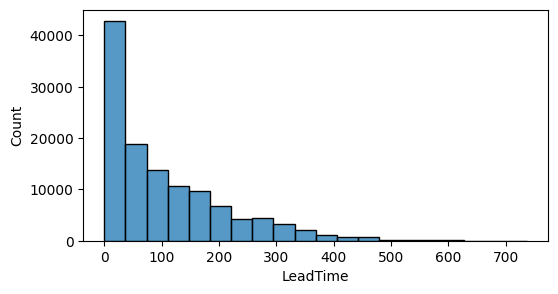

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df_prep[num_var], bins=20, ax=ax)
#sns.kdeplot(df_prep[num_var], ax=ax)
plt.show()

In [ ]:
# cut
df_prep[num_var+'_cut'] = pd.cut(df_prep[num_var], bins = 10)

In [ ]:
df_prep[num_var+'_cut'].value_counts()

(-0.737, 73.7]    61638
(73.7, 147.4]     24403
(147.4, 221.1]    16345
(221.1, 294.8]     8658
(294.8, 368.5]     5265
(368.5, 442.2]     1825
(442.2, 515.9]      844
(515.9, 589.6]      247
(589.6, 663.3]      162
(663.3, 737.0]        2
Name: LeadTime_cut, dtype: int64

### qcut (Equipopulation)

Similar al anterior con la pecularidad de que los tramos nos los definen los cuartiles. De manera que dejamos la misma población (population) en cada tramo.


In [ ]:
# qcut
df_prep[num_var+'_qcut'] = pd.qcut(df_prep[num_var], q = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

In [ ]:
df_prep[num_var+'_qcut'].value_counts() #Esta desordenado

(-0.001, 3.0]     13690
(26.0, 45.0]      12366
(99.0, 138.0]     12047
(11.0, 26.0]      11959
(184.0, 265.0]    11959
(138.0, 184.0]    11913
(265.0, 737.0]    11788
(69.0, 99.0]      11784
(45.0, 69.0]      11666
(3.0, 11.0]       10217
Name: LeadTime_qcut, dtype: int64

IMPORTANTE!!! Hay que guardar estas categorizaciones para tenerlas disponibles en producción!

# Variables categóricas

## Modelos geométricos

Estos modelos tan sólo trabajan con variables numéricas.

### Formato ordinal

Hay variables categóricas que siguen un orden.

En el dataset original no hay una variable ordinal per se, pero cualquier variable numérica categorizada tiene sentido ordinal.

In [ ]:
df_prep[num_var+'_qcut'].value_counts()

(-0.001, 3.0]     13690
(26.0, 45.0]      12366
(99.0, 138.0]     12047
(11.0, 26.0]      11959
(184.0, 265.0]    11959
(138.0, 184.0]    11913
(265.0, 737.0]    11788
(69.0, 99.0]      11784
(45.0, 69.0]      11666
(3.0, 11.0]       10217
Name: LeadTime_qcut, dtype: int64

Esta variable puede ser mapeada del 1 al 10.

In [ ]:
df_prep[num_var+'_qcut_ordinal'] = df_prep[num_var+'_qcut'].astype('category').cat.codes

In [ ]:
df_prep[[num_var, num_var+'_qcut', num_var+'_qcut_ordinal']]

,LeadTime,LeadTime_qcut,LeadTime_qcut_ordinal
0,342,"(265.0, 737.0]",9
1,737,"(265.0, 737.0]",9
2,7,"(3.0, 11.0]",1
3,13,"(11.0, 26.0]",2
4,14,"(11.0, 26.0]",2
...,...,...,...
119385,23,"(11.0, 26.0]",2
119386,102,"(99.0, 138.0]",6
119387,34,"(26.0, 45.0]",3
119388,109,"(99.0, 138.0]",6


### One Hot Encoding

Variables con categorías que no se pueden pasar a ordinales, pero nos gustaría que el modelo geométrico las tuviera en cuenta.

Por ejemplo: MarketSegment.

In [ ]:
cat_var = 'MarketSegment'

df_prep[cat_var].value_counts()

Online TA        56477
Offline TA/TO    24218
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: MarketSegment, dtype: int64

Generaremos tantas columnas como segmentos tengamos.

In [ ]:
pd.get_dummies(df,columns=['MarketSegment'])

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,LengthOfStay,Revenue,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,MarketSegment_Undefined
0,False,342,2015,July,27,1,0,0,2,0.0,...,0,0.00,0,0,0,1,0,0,0,0
1,False,737,2015,July,27,1,0,0,2,0.0,...,0,0.00,0,0,0,1,0,0,0,0
2,False,7,2015,July,27,1,0,1,1,0.0,...,1,75.00,0,0,0,1,0,0,0,0
3,False,13,2015,July,27,1,0,1,1,0.0,...,1,75.00,0,0,1,0,0,0,0,0
4,False,14,2015,July,27,1,0,2,2,0.0,...,2,196.00,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,False,23,2017,August,35,30,2,5,2,0.0,...,7,672.98,0,0,0,0,0,1,0,0
119386,False,102,2017,August,35,31,2,5,3,0.0,...,7,1578.01,0,0,0,0,0,0,1,0
119387,False,34,2017,August,35,31,2,5,2,0.0,...,7,1103.97,0,0,0,0,0,0,1,0
119388,False,109,2017,August,35,31,2,5,2,0.0,...,7,730.80,0,0,0,0,0,0,1,0


A tener en cuenta: Realizar One Hot Encoding en columnas con muchos valores únicos (variables muy cardinales) no es recomendado.

Como norma general, los modelos geométricos ni la gran mayoría de modelos lógicos no trabajan bien con datos sparse. (Una matriz o tabla sparse es una matriz que contiene muchos elementos cuyo valor es cero.)

Es recomendable Agrupar Categorías (Véase Agrupamiento de categorías).

## Modelos lógicos

### One hot encoding

Como hemos visto arriba.

### Formato ordinal

Como hemos visto arriba.

### Label Encoding

Convertimos una variable string a categórica. Se le asigna un id. Es el contrapuesto a One Hot Encoding.

En lugar de generar tantas columnas como categorías tengamos, identificamos con un valor cada columna.

In [ ]:
cat_var = 'DistributionChannel'

In [ ]:
le = LabelEncoder()
df_prep[cat_var+'_enc'] = le.fit_transform(df_prep[cat_var])

In [ ]:
df_prep[[cat_var, cat_var+'_enc']].value_counts()

DistributionChannel  DistributionChannel_enc
TA/TO                3                          97869
Direct               1                          14645
Corporate            0                           6677
GDS                  2                            193
Undefined            4                              5
dtype: int64

In [ ]:
del df_prep[cat_var+'_enc']

### Agrupamiento de categorías

Variables categóricas con muchas categorías únicas.

Ley de Pareto: Reducir a aquellas categorías más importantes.

In [ ]:
cat_var = 'Country'

In [ ]:
df_prep[cat_var].value_counts()

PRT    48589
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: Country, Length: 177, dtype: int64

In [ ]:
top = df_prep[cat_var].value_counts().to_frame().head(10)
top

,Country
PRT,48589
GBR,12129
FRA,10415
ESP,8568
DEU,7287
ITA,3766
IRL,3375
BEL,2342
BRA,2224
NLD,2104


In [ ]:
df_prep[cat_var+'_grouped'] = df_prep[cat_var]
df_prep.loc[df_prep[cat_var].isin(top.index) == False, cat_var+'_grouped']

12        USA
30        NaN
39        ROU
43        ROU
47        NOR
         ... 
119365    JPN
119375    AUT
119376    AUT
119377    CHE
119382    JPN
Name: Country_grouped, Length: 18590, dtype: object

In [ ]:
df_prep.loc[df_prep[cat_var].isin(top.index) == False, cat_var+'_grouped'] = 'Other'

In [ ]:
df_prep[cat_var+'_grouped'].value_counts()

PRT      48589
Other    18590
GBR      12129
FRA      10415
ESP       8568
DEU       7287
ITA       3766
IRL       3375
BEL       2342
BRA       2224
NLD       2104
Name: Country_grouped, dtype: int64

# Creación del modelo

Hagamos un PoC (Proof of Concept) tomando una muestra de las variables y aplicando la transformación que mejor se ajusta a la distribución.

In [ ]:
df_prep.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'HotelId', 'LengthOfStay', 'Revenue', 'Adults_clip', 'LeadTime_cut',
       'LeadTime_qcut', 'LeadTime_qcut_ordinal', 'Country_grouped'],
      dtype='object')

In [ ]:
model_df = df_prep.copy(deep=True)

In [ ]:
def num_features_prep(ori_df, num_var_prep):
    df = ori_df.copy(deep=True)
    cols = []
    for col, prep in num_var_prep.items():
        if prep is None:
          cols.append(col)
          pass
        else:
            print('\n',col, prep)
            if prep == 'qcut':
                df[col] = pd.qcut(df[col], q=[0.0, 0.25, 0.5, 0.75, 1.0])
                print(df[col].value_counts())

            elif prep == 'cut':
                df[col] = pd.cut(df[col], bins=10)
                print(df[col].value_counts())

            elif prep == 'log':
                df[col] = np.log(df[col]+1)

            if prep == 'cut' or prep == 'qcut':
                # convert them to ordinal
                df[col] = df[col].astype('category').cat.codes

            cols.append(col)

    return df, cols

In [ ]:
num_var_prep = {
    'LeadTime': None,
    'ADR': None,
    'Adults' : 'cut',
    'Children': 'cut',
    'LengthOfStay': 'qcut',
    'Revenue':'log'
}

In [ ]:
model_df, num_vars = num_features_prep(model_df, num_var_prep)


 Adults cut
(-0.055, 5.5]    119375
(22.0, 27.5]          7
(5.5, 11.0]           2
(16.5, 22.0]          2
(49.5, 55.0]          2
(38.5, 44.0]          1
(11.0, 16.5]          0
(27.5, 33.0]          0
(33.0, 38.5]          0
(44.0, 49.5]          0
Name: Adults, dtype: int64

 Children cut
(-0.01, 1.0]    115656
(1.0, 2.0]        3652
(2.0, 3.0]          76
(9.0, 10.0]          1
(3.0, 4.0]           0
(4.0, 5.0]           0
(5.0, 6.0]           0
(6.0, 7.0]           0
(7.0, 8.0]           0
(8.0, 9.0]           0
Name: Children, dtype: int64

 LengthOfStay qcut
(-0.001, 2.0]    49377
(2.0, 3.0]       27076
(4.0, 69.0]      25553
(3.0, 4.0]       17383
Name: LengthOfStay, dtype: int64

 Revenue log


In [ ]:
model_df[num_vars]

,LeadTime,ADR,Adults,Children,LengthOfStay,Revenue
0,342,0.00,0,0,0,0.000000
1,737,0.00,0,0,0,0.000000
2,7,75.00,0,0,0,4.330733
3,13,75.00,0,0,0,4.330733
4,14,98.00,0,0,0,5.283204
...,...,...,...,...,...,...
119385,23,96.14,0,0,3,6.513200
119386,102,225.43,0,0,3,7.364553
119387,34,157.71,0,0,3,7.007573
119388,109,104.40,0,0,3,6.595507


In [ ]:
def cat_features_prep(ori_df, cat_var_prep):
    df = ori_df.copy(deep=True)
    cols = []
    for col, prep in cat_var_prep.items():
        if prep is None:
            pass
        else:
            print('\n',col, prep)
            if prep == 'to_numeric':
                df[col] = df[col].astype(str).astype(int)
                cols.append(col)

            elif prep == 'top_encoding':
                top = df[col].value_counts().to_frame().head(10)
                df.loc[df[col].isin(top.index) == False, col] = 'Other'
                print(df[col].value_counts())

                # Apply label encoding after
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col])
                cols.append(col)

            elif prep == 'one_hot':
                print(df[col].value_counts())
                df = pd.get_dummies(df, columns=[col], prefix_sep='_')
                onehot_cols = [c for c in df.columns if col in c]
                print(onehot_cols)
                cols += onehot_cols

            elif prep == 'label_encoder':
                print(df[col].value_counts())
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col])
                cols.append(col)

    return df, cols

In [ ]:
cat_var_prep = {
    'ArrivalDateYear':'to_numeric',
    'ArrivalDateMonth': None,
    'ArrivalDateWeekNumber' : None,
    'ArrivalDateDayOfMonth': None,
    'HotelId':None,
    'ReservedRoomType': 'label_encoder',
    'Country': 'top_encoding',
    'MarketSegment': 'label_encoder',
    'DistributionChannel': 'one_hot'
}

In [ ]:
model_df, cat_vars = cat_features_prep(model_df, cat_var_prep)


 ArrivalDateYear to_numeric

 ReservedRoomType label_encoder
A    85993
D    19201
E     6535
F     2897
G     2094
B     1118
C      932
H      601
P       12
L        6
Name: ReservedRoomType, dtype: int64

 Country top_encoding
PRT      48589
Other    18590
GBR      12129
FRA      10415
ESP       8568
DEU       7287
ITA       3766
IRL       3375
BEL       2342
BRA       2224
NLD       2104
Name: Country, dtype: int64

 MarketSegment label_encoder
Online TA        56477
Offline TA/TO    24218
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: MarketSegment, dtype: int64

 DistributionChannel one_hot
TA/TO        97869
Direct       14645
Corporate     6677
GDS            193
Undefined        5
Name: DistributionChannel, dtype: int64
['DistributionChannel_Corporate', 'DistributionChannel_Direct', 'DistributionChannel_GDS', 'DistributionChannel_TA/TO', 'DistributionChannel_Undefined']


In [ ]:
model_df[cat_vars]

,ArrivalDateYear,ReservedRoomType,Country,MarketSegment,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_GDS,DistributionChannel_TA/TO,DistributionChannel_Undefined
0,2015,2,10,3,0,1,0,0,0
1,2015,2,10,3,0,1,0,0,0
2,2015,0,5,3,0,1,0,0,0
3,2015,0,5,2,1,0,0,0,0
4,2015,0,5,6,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
119385,2017,0,0,5,0,0,0,1,0
119386,2017,4,4,6,0,0,0,1,0
119387,2017,3,2,6,0,0,0,1,0
119388,2017,0,5,6,0,0,0,1,0


In [ ]:
model_vars = num_vars + cat_vars

In [ ]:
# Nulls
n = model_df.shape[0]
model_df.dropna(subset = model_vars, inplace = True)
print(model_df.shape[0], n-model_df.shape[0])

119388 1


In [ ]:
X = model_df[model_vars]
y = model_df[TARGET]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state=42)

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99     50451
        True       0.99      0.98      0.98     29538

    accuracy                           0.99     79989
   macro avg       0.99      0.99      0.99     79989
weighted avg       0.99      0.99      0.99     79989



In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.84      0.89      0.87     24714
        True       0.80      0.72      0.76     14685

    accuracy                           0.83     39399
   macro avg       0.82      0.81      0.81     39399
weighted avg       0.83      0.83      0.83     39399



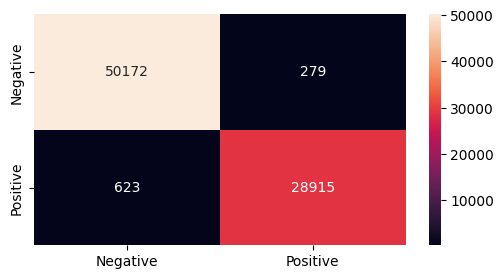

In [ ]:
ax = sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d')
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

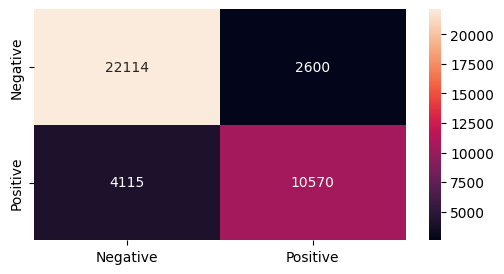

In [ ]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d')
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()